# Forecasting 3 Months of Sales
Given 5 years of daily sales data across 10 stores for 50 items, we have been tasked to forecast the next 3 months of sales. We will be exploring the data using Pandas and building models using ARIMA, tensorflow's DNN regressor, and xgboost.

Let's get started!
##### NOTE
This is my first competition and I'm still learning the models myself. At the end I share what I learned while building this.

# Import Libraries
Below are all the libraries that we'll use (with some extra for notebook aesthetics).

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme='chesterish')

from scipy.spatial.distance import euclidean #used for fdt
import fastdtw as fdt #fast dynamic time warping
from statsmodels.tsa.seasonal import seasonal_decompose #decompose seasonality
from statsmodels.tsa.stattools import adfuller #test if series is stationary (then can perform ARIMA)

from pyramid.arima import auto_arima #auto ARIMA model (pip install pyramid-arima)
import xgboost as xgb #xgboost model
import tensorflow as tf #DNN estimator model

path = ''

In [2]:
plt.rcParams["figure.figsize"] = [16,9]

# Metrics and 2 of the Models
## Error Metric
We'll be using the Symmetric Mean Absolute Percentage Error as our forecasting error metric. Defining a function saves us from writing the code multiple times.

In [3]:
def SMAPE (forecast, actual):
    """Returns the Symmetric Mean Absolute Percentage Error between two Series"""
    masked_arr = ~((forecast==0)&(actual==0))
    diff = abs(forecast[masked_arr] - actual[masked_arr])
    avg = (abs(forecast[masked_arr]) + abs(actual[masked_arr]))/2
    
    print('SMAPE Error Score: ' + str(round(sum(diff/avg)/len(forecast) * 100, 2)) + ' %')

## Stationarity Test (Dickey Fuller)
Time Series data should be stationary before applying an ARIMA model. Stationary means that the mean, standard deviation, and variance don't change over time. The function below tests whether or not a Time Series is stationary.

In [4]:
def Fuller(TimeSeries):
    """Provides Fuller test results for TimeSeries"""
    stationary_test = adfuller(TimeSeries)
    print('ADF Statistic: %f' % stationary_test[0])
    print('p-value: %f' % stationary_test[1])
    print('Critical Values:')
    for key, value in stationary_test[4].items():
        print('\t%s: %.3f' % (key, value))

## ARIMA Model
General ARIMA model that will be used.

In [5]:
def ARIMA(TimeSeries, maxP, maxQ, maxD):
    """Returns ARIMA model (not fitted)"""
    stepwise_model = auto_arima(TimeSeries, start_p=1, start_q=1,
                           max_p=maxP, max_q=maxQ,
                           start_P=0, seasonal=True,
                           d=1, max_d=maxD, D=1, trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                           maxiter=500)
    print(stepwise_model.aic())
    return stepwise_model

## XGBoost Model
General xgboost model that will be used.

In [6]:
def xboost(x_train, y_train, x_test):
    """Trains xgboost model and returns Series of predictions for x_test"""
    dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=list(x_train.columns))
    dtest = xgb.DMatrix(x_test, feature_names=list(x_test.columns))

    params = {'max_depth':3,
              'eta':0.2,
              'silent':1,
              'subsample':1}
    num_rounds = 1500

    bst = xgb.train(params, dtrain, num_rounds)
    
    return pd.Series(bst.predict(dtest))

# Data Exploration
## Retrieve Data
Open the competition training data. We'll be exploring this before splitting for our models.

In [7]:
df = pd.read_csv(path+'train.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df.tail()

,store,item,sales
date,,,
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74
2017-12-30,10,50,62
2017-12-31,10,50,82


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
store    913000 non-null int64
item     913000 non-null int64
sales    913000 non-null int64
dtypes: int64(3)
memory usage: 27.9 MB


## Store Trends
Here we're looking to see if there are any seasonality trends in the total store sales. We'll group by week so we can more clearly see trends in the plots.

In [9]:
stores = pd.DataFrame(df.groupby(['date','store']).sum()['sales']).unstack()
stores = stores.resample('7D',label='left').sum()
stores.sort_index(inplace = True)

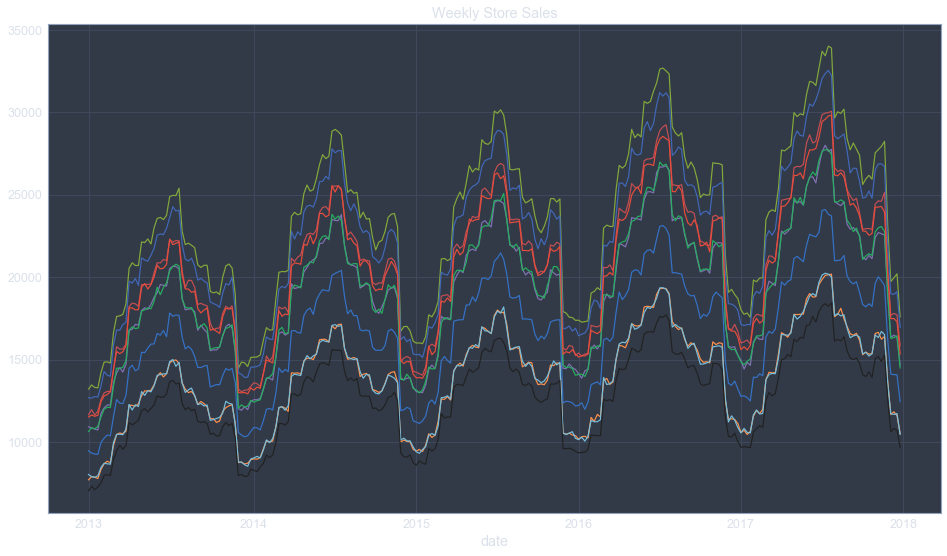

In [10]:
stores.plot(figsize=(16,9), title='Weekly Store Sales', legend=None)
plt.show()

The above plot charts every store's sales by week. But how does the average trend? The 25% quartile?

Let's look:

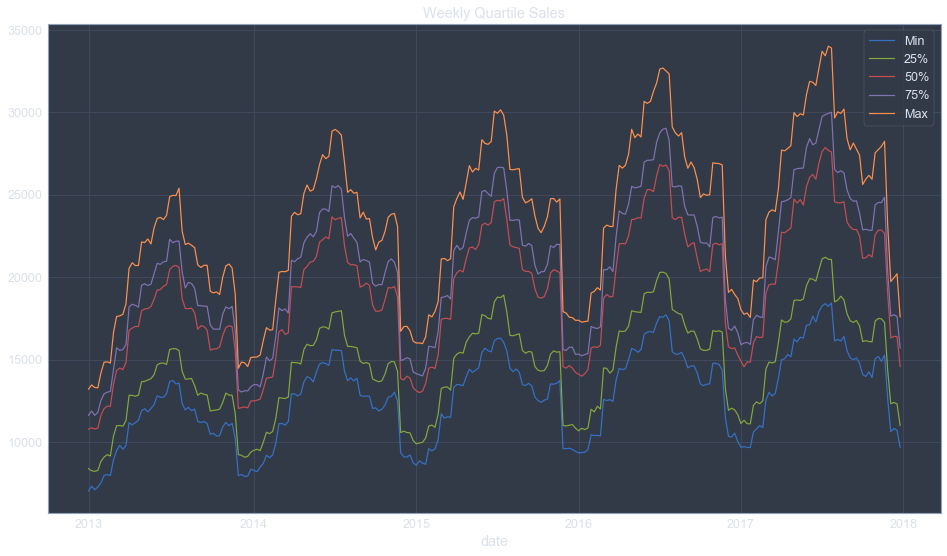

In [11]:
store_qtr = pd.DataFrame(stores.quantile([0.0,0.25,0.5,0.75,1.0],axis=1)).transpose()
store_qtr.sort_index(inplace = True)
store_qtr.columns = ['Min','25%','50%','75%','Max']
store_qtr.plot(figsize=(16,9), title='Weekly Quartile Sales')
plt.show()

We can see there's quite a gap between the 25% quartile and average. However, as the other chart shows as well, each store shares a general seasonality. They have highs and lows during the same periods of time.

Let's take a look at the seasonality aspect of the average. But before that, we're going to track the week-to-week difference.

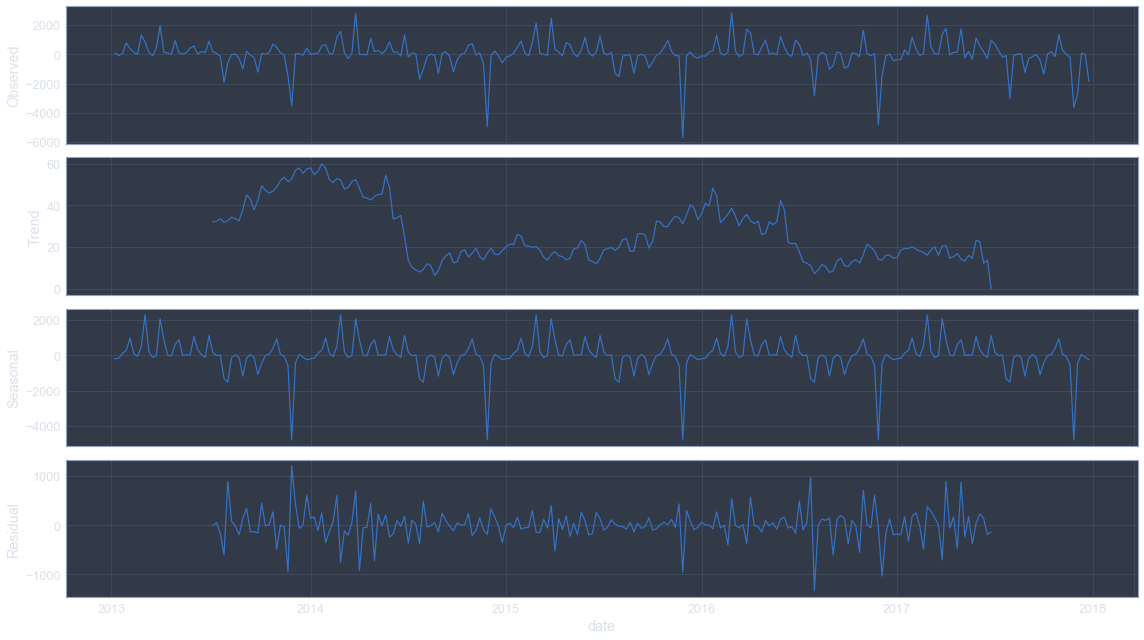

In [12]:
seasonal = seasonal_decompose(pd.DataFrame(store_qtr['50%']).diff(1).iloc[1:,0],model='additive')
seasonal.plot()
plt.suptitle = 'Additive Seasonal Decomposition of Average Store Week-to-Week Sales'
plt.show()

In [13]:
Fuller(pd.DataFrame(store_qtr['50%']).diff(1).iloc[1:,0])

ADF Statistic: -5.965889
p-value: 0.000000
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


### Store Trends Conclusion
There is definitely seasonality in the store sales. Taking the week-to-week difference provides a dataset that is very likely to be stationary (< 1% chance that it's not). If we were to use this as a starting point for our model, we could cluster the stores to the nearest 25% quartile.

## Item Sales Trends
Now we'll do the same analysis for the total item sales. And again, we're looking at weekly sales.

In [14]:
items = pd.DataFrame(df.groupby(['date','item']).sum()['sales']).unstack()
items = items.resample('7D',label='left').sum()
items.sort_index(inplace = True)

items.tail(13)

sales                                                        ...   \
item          1     2     3     4     5     6     7     8     9     10  ...    
date                                                                    ...    
2017-10-03  1769  4471  2740  1677  1372  4515  4503  5842  3917  5573  ...    
2017-10-10  1758  4454  2858  1757  1392  4483  4510  5932  3861  5771  ...    
2017-10-17  1732  4481  2856  1700  1396  4470  4606  6016  3911  5752  ...    
2017-10-24  1662  4422  2767  1724  1456  4476  4478  6083  3873  5654  ...    
2017-10-31  1774  4798  3087  1680  1476  4766  4837  6415  4276  6088  ...    
2017-11-07  1735  4887  3143  1879  1540  4686  4867  6403  4335  6161  ...    
2017-11-14  1824  4812  3094  1816  1479  4882  4854  6439  4251  5965  ...    
2017-11-21  1818  4840  3076  1876  1576  4835  4936  6427  4181  6053  ...    
2017-11-28  1490  4042  2527  1509  1301  4137  3932  5415  3548  5108  ...    
2017-12-05  1311  3551  2182  1296  1179  3562  3522  4510  3018  4358  ...    
2017-12-12  1308  3498  2251  1277  1125  3541  3381  4699  3014  4372  ...    
2017-12-19  1262  3450  2181  1306  1085  3463  3477  4516  2971  4428  ...    
2017-12-26  1167  3180  1956  1150  1000  2973  3170  4065  2764  3722  ...    

                                                                        
item          41    42    43    44    45    46    47    48    49    50  
date                                                                    
2017-10-03  1629  2845  3963  2416  6089  4620  1696  3973  2285  5054  
2017-10-10  1741  2815  3892  2338  6213  4529  1644  3949  2208  4967  
2017-10-17  1619  2778  4005  2245  6198  4560  1700  3949  2260  5070  
2017-10-24  1644  2761  3927  2346  6404  4494  1739  4021  2202  5074  
2017-10-31  1817  3038  4318  2386  6623  4889  1798  4257  2468  5323  
2017-11-07  1764  3067  4358  2408  6711  4947  1820  4291  2417  5542  
2017-11-14  1807  3076  4315  2424  6774  4884  1755  4318  2475  5349  
2017-11-21  1872  2987  4273  2392  6530  4915  1860  4329  2364  5517  
2017-11-28  1610  2635  3529  2051  5524  4028  1591  3580  1991  4503  
2017-12-05  1280  2148  2985  1756  4695  3510  1283  3101  1669  3829  
2017-12-12  1349  2213  3100  1785  4721  3483  1279  3051  1701  3856  
2017-12-19  1240  2115  3162  1669  4772  3524  1361  3177  1689  3900  
2017-12-26  1124  1893  2680  1546  4349  3182  1166  2655  1546  3411  

[13 rows x 50 columns]

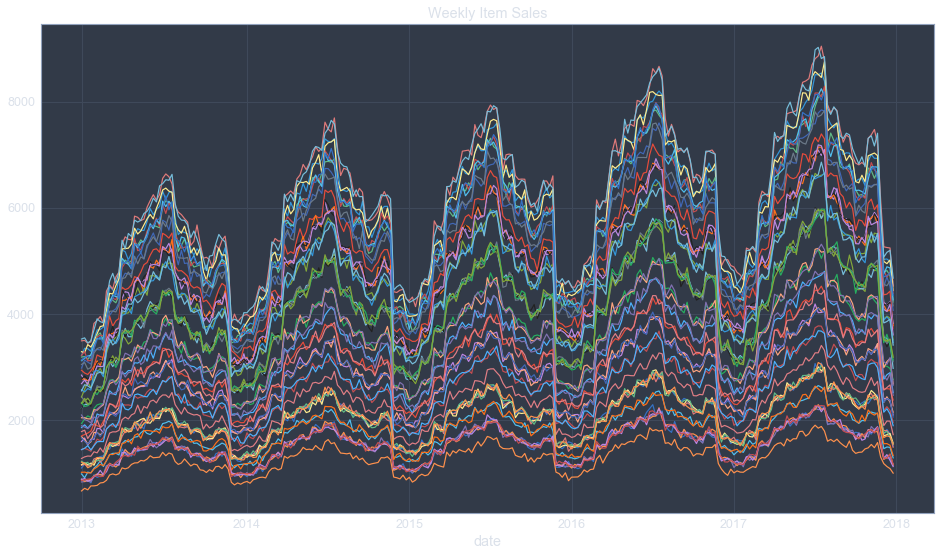

In [15]:
items.plot(figsize=(16,9), title='Weekly Item Sales', legend=None)
plt.show()

Since there are more items than there were stores, we can look at more quartiles. Let's see how every 10% quartile trends.

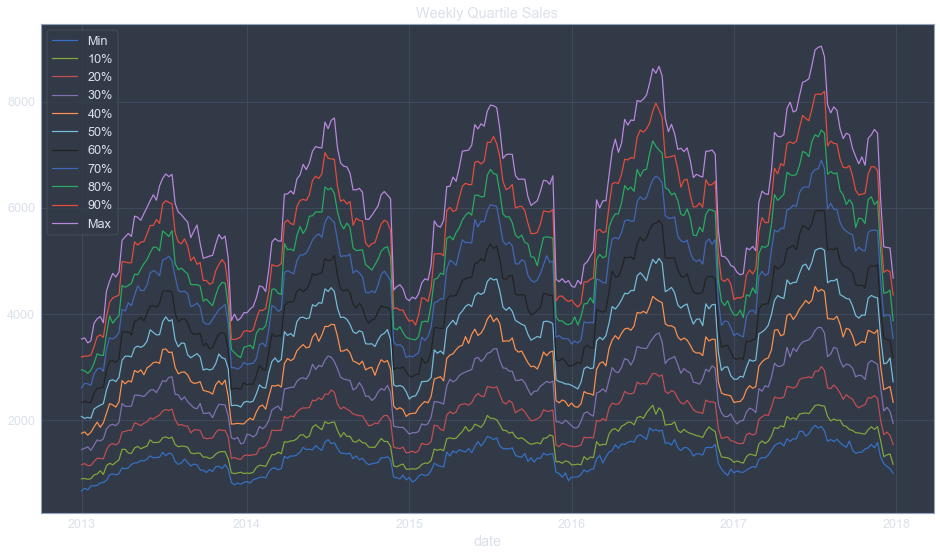

In [16]:
item_WK_qtr = pd.DataFrame(items.quantile([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],axis=1)).transpose()
item_WK_qtr.sort_index(inplace = True)
item_WK_qtr.columns = ['Min','10%','20%','30%','40%','50%','60%','70%','80%','90%','Max']
item_WK_qtr.plot(figsize=(16,9), title='Weekly Quartile Sales')
plt.show()

Like we saw in the store sales plots, there is seasonality in item sales. Let's break out the seasonal component for the average like we had before:

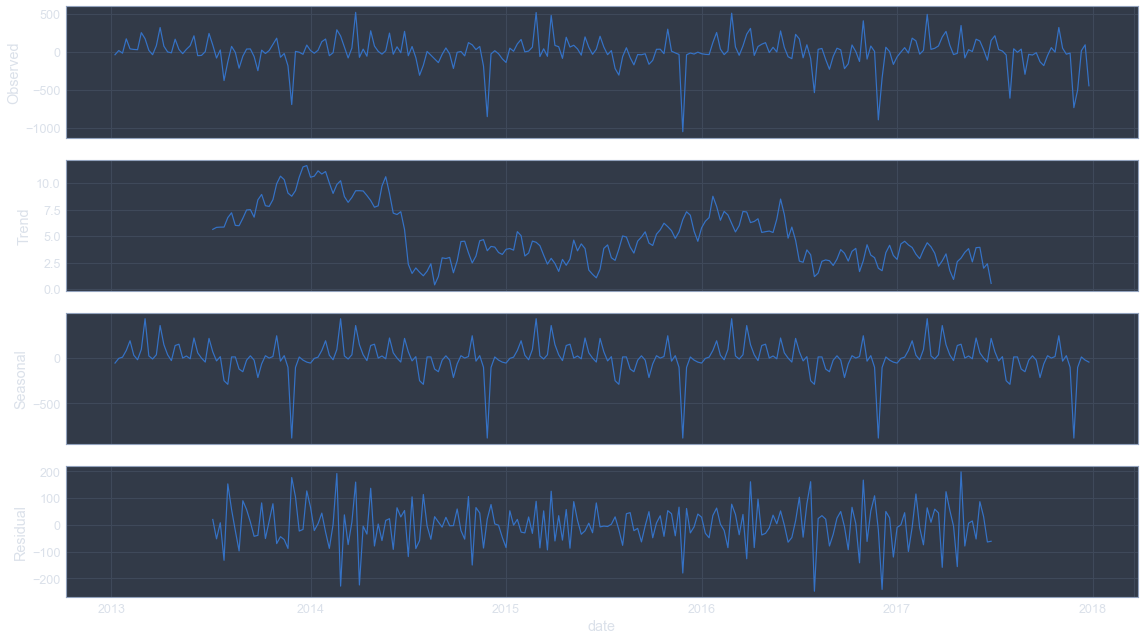

In [17]:
seasonal = seasonal_decompose(pd.DataFrame(item_WK_qtr['50%']).diff(1).iloc[1:,0],model='additive')
seasonal.plot()
plt.title = 'Additive Seasonal Decomposition of Average Item Week-to-Week Sales'
plt.show()

In [18]:
Fuller(pd.DataFrame(item_WK_qtr['50%']).diff(1).iloc[1:,0])

ADF Statistic: -13.061788
p-value: 0.000000
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


### Item Trend Conclusion
Item sales are also seasonal. No surprise there. Week-to-week differencing provides a dataset that is very likely to be stationary (< 1% chance that it's not). If we were to use this as a basis for our model, we could cluster the items to the nearest 10% quartiles.

## Store & Item Variability
We've seen how stores and items trend by themselves, but do some stores sell more of one item? In other words: do the stores have the same sales mix? Are the items sold evenly (percentage-wise) across all stores?

Below is a plot for the % distribution of each item's sales across the stores (each row adds to 100%). As we can see, it's very uniform. The takeaway here is that the items are sold evenly across the stores.

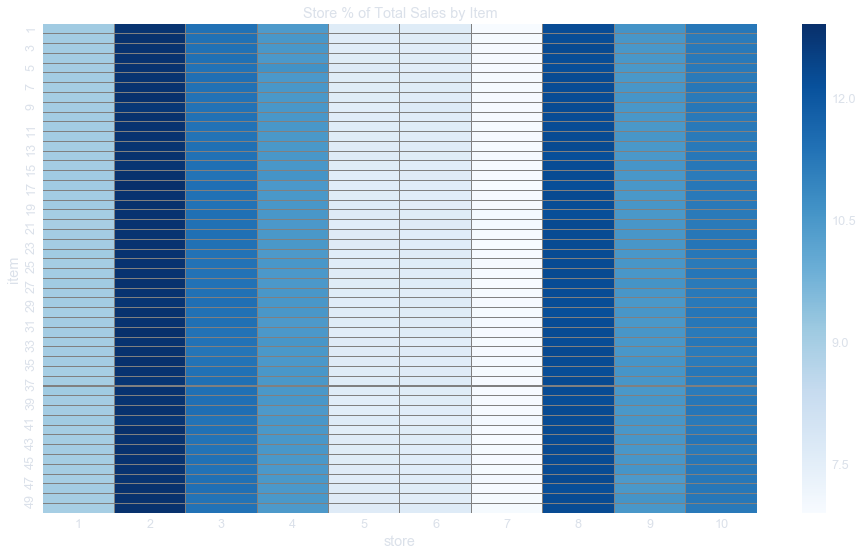

In [19]:
store_item = df.groupby(by=['item','store']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack()
sns.heatmap(store_item, cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Store % of Total Sales by Item')
plt.show()

Now to confirm, let's look at the % distribution of each store's sales across the different items (each row adds to 100%).

We can see that each store overall sold roughly the same percentage of each item.

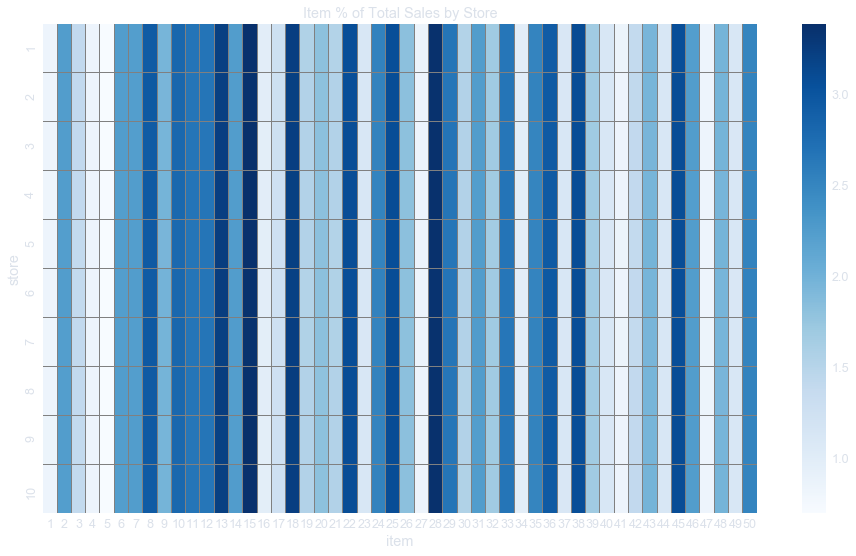

In [20]:
item_store = df.groupby(by=['store','item']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack()
sns.heatmap(item_store , cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Item % of Total Sales by Store')
plt.show()

### Store vs Item Conclusion
Items have roughly same percentage sales across all stores. We could use this in our model.

## Day of Week Variability
How do sales vary by day of week? Is there seasonality as well? Do stores share same trends? 

In [21]:
df['Day'] = df.index.weekday_name
df.head()

,store,item,sales,Day
date,,,,
2013-01-01,1,1,13,Tuesday
2013-01-02,1,1,11,Wednesday
2013-01-03,1,1,14,Thursday
2013-01-04,1,1,13,Friday
2013-01-05,1,1,10,Saturday


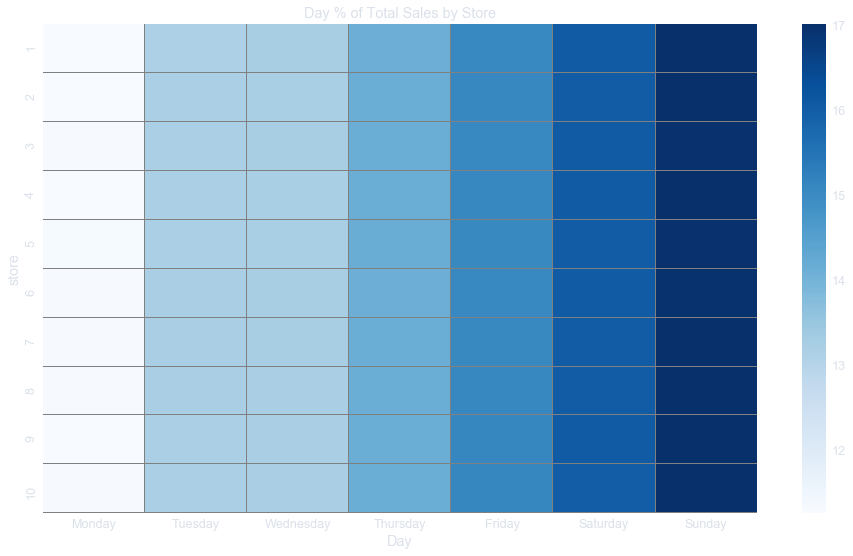

In [22]:
dow_store = df.groupby(['store','Day']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack().loc[:,['Monday',
                                                'Tuesday',
                                                'Wednesday',
                                                'Thursday',
                                                'Friday',
                                                'Saturday',
                                                'Sunday']]
sns.heatmap(dow_store, cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Day % of Total Sales by Store')
plt.show()

The plot above shows the % mix of store sales by day. We can see that the stores are very similar in what days are popular.

Let's do the same for the items.

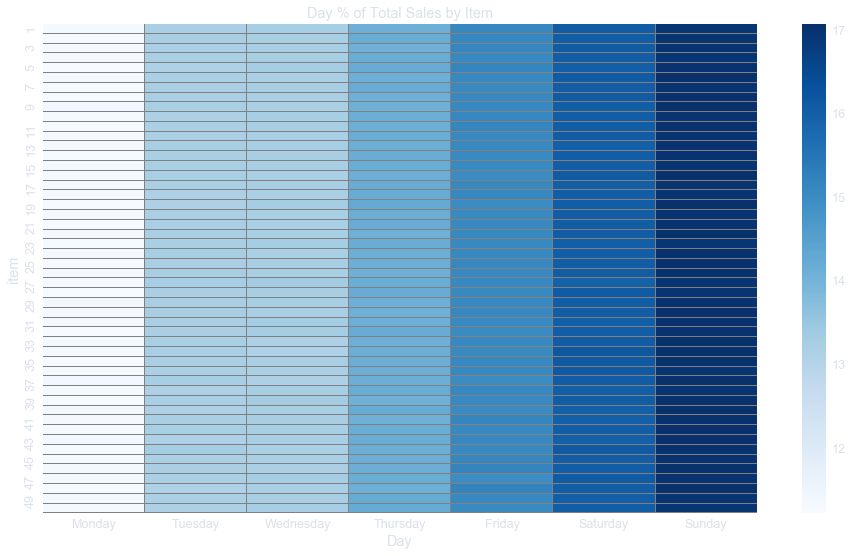

In [23]:
dow_item = df.groupby(['item','Day']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack().loc[:,['Monday',
                                                'Tuesday',
                                                'Wednesday',
                                                'Thursday',
                                                'Friday',
                                                'Saturday',
                                                'Sunday']]
sns.heatmap(dow_item, cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Day % of Total Sales by Item')
plt.show()

This plot tells us that each item's sales are nearly identical in terms of which days are more popular.

Now let's see if each day generally trends the same as the total week.

In [24]:
dow = pd.DataFrame(df.groupby(['date','Day']).sum()['sales']).unstack()['sales'].loc[:,
                                                                                ['Monday',
                                                                               'Tuesday',
                                                                               'Wednesday',
                                                                               'Thursday',
                                                                               'Friday',
                                                                               'Saturday',
                                                                               'Sunday']]
dow = dow.resample('7D',label='left').sum()
dow.sort_index(inplace = True)

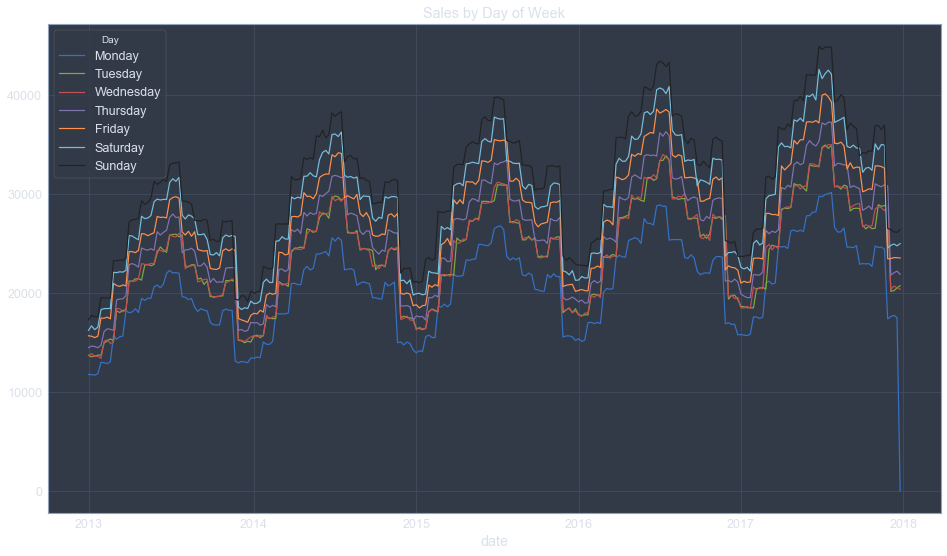

In [25]:
dow.plot(figsize=(16,9), title='Sales by Day of Week')
plt.show()

### Day of Week Conclusion
Day of week does impact sales, however all stores & items have similar distributions. Day of week trends follow general weekly trend.

## Findings and Steps Forward
Items and stores weekly sales have seasonality and can be munged into a stationary dataset. They also have similar day of week variability, and items have roughly same distributions in stores.

### Modeling Process
Split the data into train and test data (3 months of test). Will compare several models, all of which are outlined below. The goal is to find the model with the best accuracy.
#### Model (1.1)
+ Dynamic Time Warping (DTW) on item *__weekly__* sales to cluster to nearest 10% quartile
+ Forecast with *__ARIMA__*
+ Percentages will be used to find item sales by store by day

#### Model (1.2)
+ Forecast weekly item sales with *__ARIMA__*
+ Percentages will be used to find item sales by store by day

#### Model (2)
+ Item *__daily__* sales with added features:
 + Day of year (in mod 364)
 + Day of week (numeric)
 + Month
 + Year
 + Prior year sales
 + Whether or not a weekend (Fri-Sun)
 + Dynamic Time Warping (DTW) on item weekly sales to cluster to nearest 10% quartile
+ Forecast with *__feed forward neural network__*

#### Model (3)
+ Item *__daily__* sales with added features:
 + Day of year (in mod 364)
 + Day of week (numeric)
 + Month
 + Year
 + Prior year sales
 + Whether or not a weekend (Fri-Sun)
 + Dynamic Time Warping (DTW) on item weekly sales to cluster to nearest 10% quartile
+ Forecast with *__xgboost__*

# ARIMA Models
## Model (1.1) - Clustered Weekly Data

Will be using the 10% quartile weekly item sales that was created during the exploratory analysis. Since the competition is predicting the next 3 months of sales, we will use 3 months (13 weeks) of test data.

We will build an ARIMA model for each quartile then use clustering and percentages to arrive at daily items sales by store.

In [26]:
train = item_WK_qtr[:-13]
test = df.loc[df.index >= pd.to_datetime('October 3, 2017')] # last 13 weeks of data

In [27]:
store_pct = store_item.transpose()
store_pct

item,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
store,,,,,,,,,,,,,,,,,,,,,
1,9.085564,9.073791,9.062798,9.066774,9.049011,9.069617,9.018065,9.028203,9.049435,9.061402,...,9.091271,9.023547,9.015145,9.046201,9.024192,9.011790,9.005155,9.063957,9.020410,9.007414
2,12.816904,12.858324,12.824640,12.828092,12.822540,12.810300,12.823723,12.877231,12.741440,12.850031,...,12.757648,12.910997,12.825060,12.853127,12.828966,12.827383,12.810710,12.857803,12.855471,12.844459
3,11.405039,11.405115,11.399713,11.411098,11.361155,11.453447,11.386753,11.373289,11.381009,11.387498,...,11.357555,11.392619,11.345828,11.356511,11.398149,11.382714,11.416667,11.430911,11.337725,11.377637
4,10.435394,10.536256,10.520157,10.488994,10.635385,10.472900,10.528670,10.502894,10.516433,10.521691,...,10.529945,10.504758,10.531103,10.528659,10.509172,10.474110,10.504977,10.469840,10.513140,10.461351
5,7.615152,7.595244,7.596620,7.622161,7.672941,7.617378,7.608884,7.610874,7.557394,7.580473,...,7.649611,7.558458,7.634991,7.624657,7.622733,7.628759,7.589458,7.649330,7.626250,7.637765
6,7.605435,7.603005,7.589895,7.611960,7.567640,7.606987,7.619737,7.587459,7.678561,7.588026,...,7.548057,7.602791,7.609901,7.593175,7.587462,7.595511,7.593689,7.604753,7.561284,7.667690
7,6.896388,6.951524,6.967704,6.977734,6.936133,6.957439,6.955239,6.981670,6.986196,6.985992,...,7.031828,6.933015,6.906426,6.954962,6.937566,6.962599,7.034927,6.937165,6.956239,6.955393
8,12.275527,12.233490,12.301689,12.243629,12.216389,12.299760,12.255129,12.275640,12.296844,12.265646,...,12.287964,12.304810,12.278209,12.311782,12.278019,12.279176,12.339060,12.216875,12.283843,12.290432
9,10.611534,10.549439,10.516570,10.517856,10.497569,10.497144,10.560575,10.563672,10.528475,10.529543,...,10.540399,10.532970,10.557261,10.534061,10.559598,10.574879,10.454452,10.511004,10.585387,10.520038


#### Dynamic Time Warping to 10% Quartiles
Matches each item to nearest 10% quartile. Outputs list of item id, % quartile /10, and dtw score.

In [28]:
fitted_items_WK = []
qtr_list = [0] *11

for column in items:
    for c in range(11):
        qtr_list[c] = [fdt.fastdtw(items[column],item_WK_qtr.iloc[:,c], dist= euclidean)[0], c]
    qtr_list.sort()
    fitted_items_WK.append([column[1], qtr_list[0][1], qtr_list[0][0]])

#### Fitting Models and Forecasting

In [29]:
ARIMA_predictions = pd.DataFrame()

for column in item_WK_qtr:
    model = ARIMA(item_WK_qtr[column], 52, 52, 52)
    model.fit(train[column])
    ARIMA_predictions[column] = model.predict(n_periods=13)

3049.6417768558194
3086.614564046098
3197.7717643577444
3332.275339581939
3405.889532659832
3475.136067209135
3538.465431648969
3604.1951850408213
3658.8425632919193
3700.589050589141
3749.329421354075


Use item quartile fittings to assign each item a forecast from ARIMA model.

In [30]:
item_WK_predictions = pd.DataFrame()

for i in range(50):
    item_WK_predictions[fitted_items_WK[i][0]] = ARIMA_predictions.iloc[:,fitted_items_WK[i][1]]

item_WK_predictions.head()

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
0,1806.647165,4775.086934,2973.300279,1806.647165,1433.101215,4775.086934,4775.086934,6063.280035,4131.408858,6063.280035,...,1806.647165,2973.300279,4131.408858,2394.891201,6575.725694,4775.086934,1806.647165,4131.408858,2394.891201,5497.297984
1,1810.191385,4783.570536,2979.141170,1810.191385,1436.202429,4783.570536,4783.570536,6073.639819,4139.012251,6073.639819,...,1810.191385,2979.141170,4139.012251,2399.891614,6588.217021,4783.570536,1810.191385,4139.012251,2399.891614,5507.238798
2,1813.735605,4792.054137,2984.982061,1813.735605,1439.303644,4792.054137,4792.054137,6085.851934,4146.615644,6085.851934,...,1813.735605,2984.982061,4146.615644,2404.892026,6600.708348,4792.054137,1813.735605,4146.615644,2404.892026,5517.179611
3,1817.279824,4800.537739,2990.822952,1817.279824,1442.404858,4800.537739,4800.537739,6098.338985,4154.219036,6098.338985,...,1817.279824,2990.822952,4154.219036,2409.892439,6613.199676,4800.537739,1817.279824,4154.219036,2409.892439,5527.120425
4,1820.824044,4809.021341,2996.663842,1820.824044,1445.506073,4809.021341,4809.021341,6110.866845,4161.822429,6110.866845,...,1820.824044,2996.663842,4161.822429,2414.892851,6625.691003,4809.021341,1820.824044,4161.822429,2414.892851,5537.061238


#### Convert Item Weekly Predictions to Daily Predictions
Use day of week percentages from before to calculate daily item sales.

In [31]:
item_Day_pred = []

for column in item_WK_predictions:
    for i, row in item_WK_predictions.iterrows():
        for col in range(7):
            item_Day_pred.append([i, dow_item.columns[col], column, dow_item.iloc[int(column)-1,col]
                                 * item_WK_predictions[column][i]/100])
            
item_Day_fcst = pd.DataFrame(item_Day_pred, columns=['Week #','Day','item','Prediction'])

item_Day_fcst.head()

,Week #,Day,item,Prediction
0,0,Monday,1,204.356413
1,0,Tuesday,1,238.240275
2,0,Wednesday,1,239.820141
3,0,Thursday,1,254.777112
4,0,Friday,1,273.082859


#### Split Predictions by Store
Reshape the store_item DataFrame and use percentages to calculate daily item sales by store.

In [32]:
store_item = pd.DataFrame(store_item.stack()).reset_index()
store_item.columns = ['item','store','pct']

item_Day_fcst = item_Day_fcst.merge(store_item, on= 'item')

item_Day_fcst['sales'] = item_Day_fcst['Prediction'] * item_Day_fcst['pct']/100

In [33]:
item_Day_fcst = item_Day_fcst.loc[:,['Week #','Day','store','item','sales']]

item_Day_fcst.head()

,Week #,Day,store,item,sales
0,0,Monday,1,1,18.566933
1,0,Monday,2,1,26.192164
2,0,Monday,3,1,23.306928
3,0,Monday,4,1,21.325396
4,0,Monday,5,1,15.562051


#### Convert Week Number and Day of Week into Datetime
Based on where the data was split for testing, the weeks start on Tuesdays so there's no offset then. This adds an additional day of data that we'll need to cutoff.

This is needed so we can remove the additional day in a readable way.

In [34]:
def str_to_date(row):
    """Takes day of week string and week offset to calculate date"""
    switcher = {
        'Tuesday': 0, #data starts on a Tuesday, so 0 offset
        'Wednesday': 1,
        'Thursday': 2,
        'Friday': 3,
        'Saturday': 4,
        'Sunday': 5,
        'Monday': 6
    }
    weeks = pd.to_timedelta(7* row['Week #'], unit='D')
    days = pd.to_timedelta(switcher.get(row['Day']), unit='D')
    
    return pd.to_datetime('October 3, 2017') + weeks + days


item_Day_fcst['Date'] = item_Day_fcst.apply(lambda row: str_to_date(row), axis=1)
item_Day_fcst.index = item_Day_fcst['Date']

In [35]:
item_Day_fcst.sort_values(['item','store','Date'], inplace=True)
item_Day_fcst['sales']= round(item_Day_fcst['sales'], 0)

item_Day_fcst = item_Day_fcst[['store','item','sales']].loc[
    item_Day_fcst.index < pd.to_datetime('January 1, 2018')]

#### Model Accuracy
The predictions have been organized the same as the testing data, so we can simply plug both into our error function.

In [36]:
SMAPE(item_Day_fcst['sales'], test['sales'])

SMAPE Error Score: 19.49 %


## Model (1.2) - Unclustered Weekly Data

Now that we've forecasted item quartiles, let's forecast for each item separately. This is to see if there's a difference in accuracy.

We will build an ARIMA model for each item then use percentages to arrive at daily items sales by store.

In [37]:
train = items['sales'][:-13]

#### Fitting Models and Forecasting

In [38]:
item_WK_predictions = pd.DataFrame()

for column in items['sales']:
    model = ARIMA(items['sales'][column], 52, 52, 52)
    model.fit(train[column])
    item_WK_predictions[column] = model.predict(n_periods=13)

3132.3158963255437
3568.9800426972683
3359.7771883190835
3122.5780533271814
3049.6417768558194
3580.229254385328
3561.3331717814176
3695.4787836182877
3504.379666448102
3665.542130430781
3663.5626520544383
3669.8318790548547
3727.3592227114063
3574.4855673203238
3772.91378609851
3153.761550795569
3287.017066475818
3772.766637574263
3411.2445495127563
3461.8883172498045
3393.514334060449
3719.866754169827
3258.4976881970556
3623.2924199545314
3729.9257823073794
3491.206406947083
3120.520039991852
3757.758829165792
3656.8606818337425
3400.9636511125123
3567.602307885823
3432.8545622315305
3652.777863292133
3200.4858251200394
3634.404507088175
3704.174192120304
3250.961045912688
3728.2395943296383
3442.9765421745233
3265.1651186613567
3128.457780739028
3357.05785617987
3517.429984216851
3258.262527458498
3723.265970789171
3579.6774082799107
3102.3772236083432
3481.5795254357604
3260.9430576455725
3633.7497695353177


#### Convert Item Weekly Predictions to Daily Predictions
Using day of week percentages from before.

In [39]:
item_Day_pred = []

for column in item_WK_predictions:
    for i, row in item_WK_predictions.iterrows():
        for col in range(7):
            item_Day_pred.append([i, dow_item.columns[col], column, dow_item.iloc[int(column)-1,col]
                                 * item_WK_predictions[column][i]/100])
            
item_Day_fcst = pd.DataFrame(item_Day_pred, columns=['Week #','Day','item','Prediction'])

item_Day_fcst.head()

,Week #,Day,item,Prediction
0,0,Monday,1,197.205136
1,0,Tuesday,1,229.903261
2,0,Wednesday,1,231.427842
3,0,Thursday,1,245.861406
4,0,Friday,1,263.526559


#### Split Predictions by Store
Reshape the store_item DataFrame and use percentages.

In [40]:
item_Day_fcst = item_Day_fcst.merge(store_item, on= 'item')

item_Day_fcst['sales'] = item_Day_fcst['Prediction'] * item_Day_fcst['pct']/100

In [41]:
item_Day_fcst = item_Day_fcst.loc[:,['Week #','Day','store','item','sales']]

#### Convert Week Number and Day of Week into Datetime

In [42]:
item_Day_fcst['Date'] = item_Day_fcst.apply(lambda row: str_to_date(row), axis=1)
item_Day_fcst.index = item_Day_fcst['Date']

In [43]:
item_Day_fcst.sort_values(['item','store','Date'], inplace=True)
item_Day_fcst['sales']= round(item_Day_fcst['sales'], 0)

item_Day_fcst = item_Day_fcst[['store','item','sales']].loc[
    item_Day_fcst.index < pd.to_datetime('January 1, 2018')]

#### Model Accuracy

In [44]:
SMAPE(item_Day_fcst['sales'], test['sales'])

SMAPE Error Score: 19.6 %


# DNN Model
## Model (2) - Feed Forward Neural Network with Daily Data

To really take advantage of the DNN, we need to add features. We won't be adding any rolling/ expanding windows since they'd be unreliable on the competition data. Most of the engineered features are categorical, with the exception being prior year sales.

Below are some constants we'll need to use for working with datetimes.

In [45]:
ns_per_day = 86400000000000
start_date = pd.to_datetime('January 1, 2013')

### Feature Engineering
**Day of Week**
 + Utilizing pandas builtin dayofweek call.

**Month**
 + Utilizing pandas buitlin month call.
 
**Day of Year**
 + Take the number of days since the data started, then take (mod 364) for a like-for-like day of year.
 + Want to do this instead of calendar day of year because the dates land on different days of the week. Example: January 1 might be a Tuesday one year so it'll be a Wednesday next year.
 
**Year**
 + Take the number of days since the data started, then take the quotient when divided by 364 and subtract 1. The subtraction is so we can easily remove the first year of data as there is no prior year data.
 + This is to give us similar years, same reasoning as above.
 
**Is Weekend**
 + Boolean value if the date falls on a weekend. This is because a majority of sales occur between Friday and Sunday.
 
**Item Quart**
 + Which quartile trend the item most closely resembles. This comes from the dynamic time warping we had done for the ARIMA models.
 
**12 Month Lag**
 + Prior year's sales (same store, same item, 364 days prior).

In [46]:
itm_quart = pd.DataFrame(fitted_items_WK, columns=['item','item_quart','item_metric'])

def add_feat(df):
    """Takes DataFrame and returns DataFrame with added features"""

    df['Day_of_Week'] = df.index.dayofweek
    df['Month'] = df.index.month
    df['Day_of_Year'] = ((df.index - start_date)/ ns_per_day).astype(int) % 364
    df['Year'] = ((df.index - start_date)/ ns_per_day).astype(int) // 364 -1
    df['is_wknd'] = df['Day_of_Week'] // 4 # Fri-Sun are 4-6, Monday is 0 so this works
    df.reset_index(inplace=True)
    
    # Add item quartile as feature
    df = df.merge(itm_quart, on='item').drop('item_metric', axis=1)

    # Add prior year sales as additional column/ feature
    prior_year_sales = df[['date','sales','store','item']]
    prior_year_sales['date'] += pd.Timedelta('364 days')
    prior_year_sales.columns =['date','lag_12mo','store','item']

    df = df.merge(prior_year_sales, on=['date','store','item'])
    
    # Remove first year of data as there is no prior year sales for them
    df['store'] -=1
    df['item'] -=1
    df = df[df['Year'] >=0]
    
    return df

In [47]:
df = add_feat(df)

df.tail(10)

C:\Users\Andy\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,date,store,item,sales,Day,Day_of_Week,Month,Day_of_Year,Year,is_wknd,item_quart,lag_12mo
730990,2017-12-22,9,49,75,Friday,4,12,360,3,1,7,64
730991,2017-12-23,9,49,70,Saturday,5,12,361,3,1,7,65
730992,2017-12-24,9,49,76,Sunday,6,12,362,3,1,7,64
730993,2017-12-25,9,49,51,Monday,0,12,363,3,0,7,61
730994,2017-12-26,9,49,41,Tuesday,1,12,0,4,0,7,60
730995,2017-12-27,9,49,63,Wednesday,2,12,1,4,0,7,43
730996,2017-12-28,9,49,59,Thursday,3,12,2,4,0,7,68
730997,2017-12-29,9,49,74,Friday,4,12,3,4,1,7,63
730998,2017-12-30,9,49,62,Saturday,5,12,4,4,1,7,64
730999,2017-12-31,9,49,82,Sunday,6,12,5,4,1,7,69


In [48]:
df.head(10)

,date,store,item,sales,Day,Day_of_Week,Month,Day_of_Year,Year,is_wknd,item_quart,lag_12mo
0,2013-12-31,0,0,15,Tuesday,1,12,0,0,0,1,13
1,2014-01-01,0,0,9,Wednesday,2,1,1,0,0,1,11
2,2014-01-02,0,0,14,Thursday,3,1,2,0,0,1,14
3,2014-01-03,0,0,11,Friday,4,1,3,0,1,1,13
4,2014-01-04,0,0,20,Saturday,5,1,4,0,1,1,10
5,2014-01-05,0,0,17,Sunday,6,1,5,0,1,1,12
6,2014-01-06,0,0,14,Monday,0,1,6,0,0,1,10
7,2014-01-07,0,0,11,Tuesday,1,1,7,0,0,1,9
8,2014-01-08,0,0,12,Wednesday,2,1,8,0,0,1,12
9,2014-01-09,0,0,17,Thursday,3,1,9,0,0,1,9


### Train & Test Data Split
Split train and test data by setting the last 91 days (everything after October 3, 2017) as test data.

In [49]:
x_train = df.loc[df['date'] < pd.to_datetime('October 3, 2017')].drop(['sales','date','Day'], axis=1)
y_train = df.loc[df['date'] < pd.to_datetime('October 3, 2017'), 'sales']

x_test = df.loc[df['date'] >= pd.to_datetime('October 3, 2017')].drop(['sales','date','Day'], axis=1).reset_index(drop=True)
y_test = df.loc[df['date'] >= pd.to_datetime('October 3, 2017'), 'sales'].reset_index(drop=True)

### Feature Columns
Setup the feature colunms in the tensorflow model. Most of the features are categorical, the only numeric one is 'lag_12mo'

In [50]:
feat_cols =[]

for col in x_train.drop('lag_12mo', axis=1).columns:
    feat_cols.append(tf.feature_column.embedding_column(
        tf.feature_column.categorical_column_with_identity(col, max(df[col])+1),1))
    
feat_cols.append(tf.feature_column.numeric_column(key='lag_12mo'))

### Training the Model & Forecasting
Setup the training (input) function in tensorflow. Sending 6 months (180 days) of data to train on at once and will run through the entire dataset 80 times. We won't shuffle the observations for this exercise. Idea being that the order of observations matters since this is a time series.

In [51]:
input_func = tf.estimator.inputs.pandas_input_fn(x= x_train, y= y_train, batch_size= 180, num_epochs= 80,
                                                 shuffle= False)

The model we'll use is tensorflow's builtin DNNRegressor with 3 hidden layers.

In [52]:
regressor = tf.estimator.DNNRegressor(hidden_units= [20, 10, 20], feature_columns= feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Andy\\AppData\\Local\\Temp\\tmpkrigu5_u', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000017686D42518>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [53]:
regressor.train(input_fn= input_func)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\Andy\AppData\Local\Temp\tmpkrigu5_u\model.ckpt.
INFO:tensorflow:loss = 66125.984, step = 1
INFO:tensorflow:global_step/sec: 160.352
INFO:tensorflow:loss = 25552.055, step = 101 (0.627 sec)
INFO:tensorflow:global_step/sec: 356.077
INFO:tensorflow:loss = 7501.4917, step = 201 (0.281 sec)
INFO:tensorflow:global_step/sec: 423.948
INFO:tensorflow:loss = 7639.788, step = 301 (0.235 sec)
INFO:tensorflow:global_step/sec: 423.999
INFO:tensorflow:loss = 18928.986, step = 401 (0.237 sec)
INFO:tensorflow:global_step/sec: 238.231
INFO:tensorflow:loss = 16768.33, step = 501 (0.419 sec)
INFO:tensorflow:global_step/sec: 208.02
INFO:tensorflow:loss = 28356.695, step = 601 (0.482 sec)
INFO:tensorflow:global_step/sec:

INFO:tensorflow:loss = 4983.501, step = 8001 (0.238 sec)
INFO:tensorflow:global_step/sec: 436.932
INFO:tensorflow:loss = 14248.934, step = 8101 (0.230 sec)
INFO:tensorflow:global_step/sec: 435.03
INFO:tensorflow:loss = 14713.18, step = 8201 (0.230 sec)
INFO:tensorflow:global_step/sec: 415.18
INFO:tensorflow:loss = 11748.521, step = 8301 (0.241 sec)
INFO:tensorflow:global_step/sec: 433.15
INFO:tensorflow:loss = 16928.04, step = 8401 (0.231 sec)
INFO:tensorflow:global_step/sec: 436.932
INFO:tensorflow:loss = 11076.888, step = 8501 (0.230 sec)
INFO:tensorflow:global_step/sec: 425.774
INFO:tensorflow:loss = 16096.939, step = 8601 (0.233 sec)
INFO:tensorflow:global_step/sec: 433.153
INFO:tensorflow:loss = 23387.715, step = 8701 (0.231 sec)
INFO:tensorflow:global_step/sec: 442.732
INFO:tensorflow:loss = 4348.3267, step = 8801 (0.227 sec)
INFO:tensorflow:global_step/sec: 429.431
INFO:tensorflow:loss = 13290.933, step = 8901 (0.232 sec)
INFO:tensorflow:global_step/sec: 442.733
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 363.845
INFO:tensorflow:loss = 10150.158, step = 16301 (0.276 sec)
INFO:tensorflow:global_step/sec: 379.005
INFO:tensorflow:loss = 11660.799, step = 16401 (0.262 sec)
INFO:tensorflow:global_step/sec: 420.411
INFO:tensorflow:loss = 4634.777, step = 16501 (0.240 sec)
INFO:tensorflow:global_step/sec: 423.972
INFO:tensorflow:loss = 27916.152, step = 16601 (0.235 sec)
INFO:tensorflow:global_step/sec: 416.907
INFO:tensorflow:loss = 15891.321, step = 16701 (0.240 sec)
INFO:tensorflow:global_step/sec: 387.819
INFO:tensorflow:loss = 7465.9565, step = 16801 (0.259 sec)
INFO:tensorflow:global_step/sec: 369.208
INFO:tensorflow:loss = 13505.272, step = 16901 (0.271 sec)
INFO:tensorflow:global_step/sec: 406.747
INFO:tensorflow:loss = 12060.086, step = 17001 (0.245 sec)
INFO:tensorflow:global_step/sec: 305.987
INFO:tensorflow:loss = 12690.601, step = 17101 (0.328 sec)
INFO:tensorflow:global_step/sec: 336.894
INFO:tensorflow:loss = 9207.257, step = 17201 (0.296 sec)
IN

INFO:tensorflow:loss = 14548.716, step = 24501 (0.241 sec)
INFO:tensorflow:global_step/sec: 418.647
INFO:tensorflow:loss = 7135.557, step = 24601 (0.239 sec)
INFO:tensorflow:global_step/sec: 398.64
INFO:tensorflow:loss = 15205.6, step = 24701 (0.251 sec)
INFO:tensorflow:global_step/sec: 408.398
INFO:tensorflow:loss = 10876.993, step = 24801 (0.244 sec)
INFO:tensorflow:global_step/sec: 427.593
INFO:tensorflow:loss = 2971.2183, step = 24901 (0.235 sec)
INFO:tensorflow:global_step/sec: 427.584
INFO:tensorflow:loss = 24768.135, step = 25001 (0.234 sec)
INFO:tensorflow:global_step/sec: 423.986
INFO:tensorflow:loss = 7365.994, step = 25101 (0.236 sec)
INFO:tensorflow:global_step/sec: 433.152
INFO:tensorflow:loss = 7082.701, step = 25201 (0.230 sec)
INFO:tensorflow:global_step/sec: 435.03
INFO:tensorflow:loss = 7244.533, step = 25301 (0.231 sec)
INFO:tensorflow:global_step/sec: 429.431
INFO:tensorflow:loss = 5516.226, step = 25401 (0.233 sec)
INFO:tensorflow:global_step/sec: 410.075
INFO:tens

INFO:tensorflow:global_step/sec: 436.931
INFO:tensorflow:loss = 9033.842, step = 32801 (0.229 sec)
INFO:tensorflow:global_step/sec: 435.034
INFO:tensorflow:loss = 7322.401, step = 32901 (0.230 sec)
INFO:tensorflow:global_step/sec: 431.28
INFO:tensorflow:loss = 13838.482, step = 33001 (0.232 sec)
INFO:tensorflow:global_step/sec: 425.778
INFO:tensorflow:loss = 14630.804, step = 33101 (0.235 sec)
INFO:tensorflow:global_step/sec: 389.328
INFO:tensorflow:loss = 12618.158, step = 33201 (0.258 sec)
INFO:tensorflow:global_step/sec: 400.231
INFO:tensorflow:loss = 6204.877, step = 33301 (0.249 sec)
INFO:tensorflow:global_step/sec: 400.231
INFO:tensorflow:loss = 10474.051, step = 33401 (0.250 sec)
INFO:tensorflow:global_step/sec: 427.597
INFO:tensorflow:loss = 4612.197, step = 33501 (0.235 sec)
INFO:tensorflow:global_step/sec: 442.732
INFO:tensorflow:loss = 5362.8877, step = 33601 (0.226 sec)
INFO:tensorflow:global_step/sec: 429.429
INFO:tensorflow:loss = 13686.794, step = 33701 (0.232 sec)
INFO:

INFO:tensorflow:loss = 16878.434, step = 41001 (0.227 sec)
INFO:tensorflow:global_step/sec: 429.429
INFO:tensorflow:loss = 6371.008, step = 41101 (0.234 sec)
INFO:tensorflow:global_step/sec: 433.152
INFO:tensorflow:loss = 3131.396, step = 41201 (0.230 sec)
INFO:tensorflow:global_step/sec: 440.782
INFO:tensorflow:loss = 8827.607, step = 41301 (0.228 sec)
INFO:tensorflow:global_step/sec: 427.596
INFO:tensorflow:loss = 6490.151, step = 41401 (0.234 sec)
INFO:tensorflow:global_step/sec: 423.966
INFO:tensorflow:loss = 14558.556, step = 41501 (0.236 sec)
INFO:tensorflow:global_step/sec: 433.154
INFO:tensorflow:loss = 11696.19, step = 41601 (0.231 sec)
INFO:tensorflow:global_step/sec: 438.849
INFO:tensorflow:loss = 11662.527, step = 41701 (0.227 sec)
INFO:tensorflow:global_step/sec: 413.463
INFO:tensorflow:loss = 4276.5283, step = 41801 (0.243 sec)
INFO:tensorflow:global_step/sec: 436.932
INFO:tensorflow:loss = 19335.562, step = 41901 (0.228 sec)
INFO:tensorflow:global_step/sec: 423.97
INFO:t

INFO:tensorflow:global_step/sec: 431.286
INFO:tensorflow:loss = 4600.863, step = 49301 (0.231 sec)
INFO:tensorflow:global_step/sec: 438.839
INFO:tensorflow:loss = 9181.055, step = 49401 (0.229 sec)
INFO:tensorflow:global_step/sec: 435.041
INFO:tensorflow:loss = 7731.348, step = 49501 (0.230 sec)
INFO:tensorflow:global_step/sec: 427.597
INFO:tensorflow:loss = 5281.4175, step = 49601 (0.234 sec)
INFO:tensorflow:global_step/sec: 436.932
INFO:tensorflow:loss = 7047.4287, step = 49701 (0.228 sec)
INFO:tensorflow:global_step/sec: 433.15
INFO:tensorflow:loss = 3794.9634, step = 49801 (0.231 sec)
INFO:tensorflow:global_step/sec: 406.738
INFO:tensorflow:loss = 3148.8745, step = 49901 (0.247 sec)
INFO:tensorflow:global_step/sec: 411.759
INFO:tensorflow:loss = 10752.885, step = 50001 (0.242 sec)
INFO:tensorflow:global_step/sec: 425.775
INFO:tensorflow:loss = 20792.092, step = 50101 (0.235 sec)
INFO:tensorflow:global_step/sec: 418.63
INFO:tensorflow:loss = 8092.2803, step = 50201 (0.239 sec)
INFO:

INFO:tensorflow:loss = 3573.5208, step = 57501 (0.231 sec)
INFO:tensorflow:global_step/sec: 416.907
INFO:tensorflow:loss = 8998.487, step = 57601 (0.240 sec)
INFO:tensorflow:global_step/sec: 431.269
INFO:tensorflow:loss = 18388.865, step = 57701 (0.232 sec)
INFO:tensorflow:global_step/sec: 425.788
INFO:tensorflow:loss = 12649.406, step = 57801 (0.234 sec)
INFO:tensorflow:global_step/sec: 429.434
INFO:tensorflow:loss = 10153.808, step = 57901 (0.234 sec)
INFO:tensorflow:global_step/sec: 410.072
INFO:tensorflow:loss = 17740.832, step = 58001 (0.243 sec)
INFO:tensorflow:global_step/sec: 427.588
INFO:tensorflow:loss = 13205.789, step = 58101 (0.235 sec)
INFO:tensorflow:global_step/sec: 405.098
INFO:tensorflow:loss = 9999.189, step = 58201 (0.246 sec)
INFO:tensorflow:global_step/sec: 363.845
INFO:tensorflow:loss = 16518.182, step = 58301 (0.276 sec)
INFO:tensorflow:global_step/sec: 395.484
INFO:tensorflow:loss = 9941.897, step = 58401 (0.253 sec)
INFO:tensorflow:global_step/sec: 438.849
INF

INFO:tensorflow:global_step/sec: 431.308
INFO:tensorflow:loss = 12407.064, step = 65801 (0.232 sec)
INFO:tensorflow:global_step/sec: 431.282
INFO:tensorflow:loss = 9611.457, step = 65901 (0.232 sec)
INFO:tensorflow:global_step/sec: 427.586
INFO:tensorflow:loss = 6406.8154, step = 66001 (0.234 sec)
INFO:tensorflow:global_step/sec: 422.159
INFO:tensorflow:loss = 19060.576, step = 66101 (0.236 sec)
INFO:tensorflow:global_step/sec: 435.269
INFO:tensorflow:loss = 7312.241, step = 66201 (0.230 sec)
INFO:tensorflow:global_step/sec: 433.186
INFO:tensorflow:loss = 8511.708, step = 66301 (0.232 sec)
INFO:tensorflow:global_step/sec: 436.934
INFO:tensorflow:loss = 19825.89, step = 66401 (0.229 sec)
INFO:tensorflow:global_step/sec: 408.371
INFO:tensorflow:loss = 4016.8284, step = 66501 (0.245 sec)
INFO:tensorflow:global_step/sec: 410.1
INFO:tensorflow:loss = 19387.928, step = 66601 (0.244 sec)
INFO:tensorflow:global_step/sec: 427.593
INFO:tensorflow:loss = 7469.628, step = 66701 (0.232 sec)
INFO:te

INFO:tensorflow:global_step/sec: 436.933
INFO:tensorflow:loss = 9184.016, step = 74101 (0.228 sec)
INFO:tensorflow:global_step/sec: 433.129
INFO:tensorflow:loss = 9894.438, step = 74201 (0.231 sec)
INFO:tensorflow:global_step/sec: 431.267
INFO:tensorflow:loss = 19003.676, step = 74301 (0.232 sec)
INFO:tensorflow:global_step/sec: 440.818
INFO:tensorflow:loss = 4966.065, step = 74401 (0.227 sec)
INFO:tensorflow:global_step/sec: 442.734
INFO:tensorflow:loss = 13107.269, step = 74501 (0.226 sec)
INFO:tensorflow:global_step/sec: 444.694
INFO:tensorflow:loss = 14147.346, step = 74601 (0.226 sec)
INFO:tensorflow:global_step/sec: 386.327
INFO:tensorflow:loss = 10356.285, step = 74701 (0.258 sec)
INFO:tensorflow:global_step/sec: 420.41
INFO:tensorflow:loss = 9783.863, step = 74801 (0.239 sec)
INFO:tensorflow:global_step/sec: 423.972
INFO:tensorflow:loss = 7363.3623, step = 74901 (0.236 sec)
INFO:tensorflow:global_step/sec: 423.974
INFO:tensorflow:loss = 7069.8877, step = 75001 (0.236 sec)
INFO:

INFO:tensorflow:global_step/sec: 418.65
INFO:tensorflow:loss = 6318.865, step = 82401 (0.239 sec)
INFO:tensorflow:global_step/sec: 422.184
INFO:tensorflow:loss = 16926.709, step = 82501 (0.237 sec)
INFO:tensorflow:global_step/sec: 420.411
INFO:tensorflow:loss = 3260.9038, step = 82601 (0.237 sec)
INFO:tensorflow:global_step/sec: 423.972
INFO:tensorflow:loss = 18897.158, step = 82701 (0.236 sec)
INFO:tensorflow:global_step/sec: 427.596
INFO:tensorflow:loss = 5052.5913, step = 82801 (0.235 sec)
INFO:tensorflow:global_step/sec: 418.651
INFO:tensorflow:loss = 10709.004, step = 82901 (0.239 sec)
INFO:tensorflow:global_step/sec: 429.431
INFO:tensorflow:loss = 9802.938, step = 83001 (0.233 sec)
INFO:tensorflow:global_step/sec: 411.757
INFO:tensorflow:loss = 5047.833, step = 83101 (0.242 sec)
INFO:tensorflow:global_step/sec: 413.44
INFO:tensorflow:loss = 4252.747, step = 83201 (0.242 sec)
INFO:tensorflow:global_step/sec: 413.481
INFO:tensorflow:loss = 13213.443, step = 83301 (0.243 sec)
INFO:t

INFO:tensorflow:loss = 5622.6357, step = 90601 (0.235 sec)
INFO:tensorflow:global_step/sec: 405.089
INFO:tensorflow:loss = 6032.176, step = 90701 (0.247 sec)
INFO:tensorflow:global_step/sec: 436.936
INFO:tensorflow:loss = 8530.468, step = 90801 (0.228 sec)
INFO:tensorflow:global_step/sec: 435.031
INFO:tensorflow:loss = 8015.608, step = 90901 (0.230 sec)
INFO:tensorflow:global_step/sec: 423.972
INFO:tensorflow:loss = 4935.448, step = 91001 (0.236 sec)
INFO:tensorflow:global_step/sec: 415.176
INFO:tensorflow:loss = 17608.305, step = 91101 (0.242 sec)
INFO:tensorflow:global_step/sec: 435.035
INFO:tensorflow:loss = 3767.643, step = 91201 (0.230 sec)
INFO:tensorflow:global_step/sec: 390.85
INFO:tensorflow:loss = 11834.835, step = 91301 (0.256 sec)
INFO:tensorflow:global_step/sec: 427.276
INFO:tensorflow:loss = 12866.79, step = 91401 (0.233 sec)
INFO:tensorflow:global_step/sec: 418.649
INFO:tensorflow:loss = 3481.7998, step = 91501 (0.240 sec)
INFO:tensorflow:global_step/sec: 442.736
INFO:te

INFO:tensorflow:global_step/sec: 433.154
INFO:tensorflow:loss = 7314.5825, step = 98901 (0.231 sec)
INFO:tensorflow:global_step/sec: 416.905
INFO:tensorflow:loss = 6742.4087, step = 99001 (0.239 sec)
INFO:tensorflow:global_step/sec: 418.652
INFO:tensorflow:loss = 4264.215, step = 99101 (0.240 sec)
INFO:tensorflow:global_step/sec: 358.629
INFO:tensorflow:loss = 8621.02, step = 99201 (0.278 sec)
INFO:tensorflow:global_step/sec: 400.231
INFO:tensorflow:loss = 8419.484, step = 99301 (0.250 sec)
INFO:tensorflow:global_step/sec: 403.458
INFO:tensorflow:loss = 5088.983, step = 99401 (0.248 sec)
INFO:tensorflow:global_step/sec: 411.757
INFO:tensorflow:loss = 9748.685, step = 99501 (0.244 sec)
INFO:tensorflow:global_step/sec: 389.309
INFO:tensorflow:loss = 13603.682, step = 99601 (0.257 sec)
INFO:tensorflow:global_step/sec: 433.177
INFO:tensorflow:loss = 7890.7734, step = 99701 (0.231 sec)
INFO:tensorflow:global_step/sec: 413.458
INFO:tensorflow:loss = 16906.271, step = 99801 (0.241 sec)
INFO:t

INFO:tensorflow:global_step/sec: 423.972
INFO:tensorflow:loss = 14043.128, step = 107101 (0.235 sec)
INFO:tensorflow:global_step/sec: 403.457
INFO:tensorflow:loss = 8181.7886, step = 107201 (0.248 sec)
INFO:tensorflow:global_step/sec: 427.598
INFO:tensorflow:loss = 13946.237, step = 107301 (0.234 sec)
INFO:tensorflow:global_step/sec: 407.566
INFO:tensorflow:loss = 12880.429, step = 107401 (0.246 sec)
INFO:tensorflow:global_step/sec: 422.185
INFO:tensorflow:loss = 11554.528, step = 107501 (0.237 sec)
INFO:tensorflow:global_step/sec: 425.777
INFO:tensorflow:loss = 10531.414, step = 107601 (0.234 sec)
INFO:tensorflow:global_step/sec: 411.76
INFO:tensorflow:loss = 16112.936, step = 107701 (0.243 sec)
INFO:tensorflow:global_step/sec: 405.089
INFO:tensorflow:loss = 20869.305, step = 107801 (0.247 sec)
INFO:tensorflow:global_step/sec: 411.727
INFO:tensorflow:loss = 3332.6895, step = 107901 (0.243 sec)
INFO:tensorflow:global_step/sec: 429.469
INFO:tensorflow:loss = 8362.556, step = 108001 (0.2

INFO:tensorflow:global_step/sec: 427.598
INFO:tensorflow:loss = 14456.235, step = 115301 (0.233 sec)
INFO:tensorflow:global_step/sec: 415.175
INFO:tensorflow:loss = 12702.068, step = 115401 (0.241 sec)
INFO:tensorflow:global_step/sec: 436.935
INFO:tensorflow:loss = 6120.0244, step = 115501 (0.230 sec)
INFO:tensorflow:global_step/sec: 420.408
INFO:tensorflow:loss = 3678.2034, step = 115601 (0.238 sec)
INFO:tensorflow:global_step/sec: 436.189
INFO:tensorflow:loss = 17152.234, step = 115701 (0.228 sec)
INFO:tensorflow:global_step/sec: 433.186
INFO:tensorflow:loss = 11202.256, step = 115801 (0.232 sec)
INFO:tensorflow:global_step/sec: 406.739
INFO:tensorflow:loss = 5916.8096, step = 115901 (0.245 sec)
INFO:tensorflow:global_step/sec: 408.398
INFO:tensorflow:loss = 18677.826, step = 116001 (0.246 sec)
INFO:tensorflow:global_step/sec: 422.183
INFO:tensorflow:loss = 15102.406, step = 116101 (0.236 sec)
INFO:tensorflow:global_step/sec: 429.391
INFO:tensorflow:loss = 11877.483, step = 116201 (0

INFO:tensorflow:loss = 7465.7686, step = 123401 (0.234 sec)
INFO:tensorflow:global_step/sec: 427.596
INFO:tensorflow:loss = 10112.558, step = 123501 (0.233 sec)
INFO:tensorflow:global_step/sec: 438.848
INFO:tensorflow:loss = 10109.237, step = 123601 (0.229 sec)
INFO:tensorflow:global_step/sec: 406.74
INFO:tensorflow:loss = 6949.375, step = 123701 (0.246 sec)
INFO:tensorflow:global_step/sec: 400.228
INFO:tensorflow:loss = 16861.75, step = 123801 (0.250 sec)
INFO:tensorflow:global_step/sec: 416.906
INFO:tensorflow:loss = 6392.6035, step = 123901 (0.239 sec)
INFO:tensorflow:global_step/sec: 415.145
INFO:tensorflow:loss = 3064.795, step = 124001 (0.242 sec)
INFO:tensorflow:global_step/sec: 442.77
INFO:tensorflow:loss = 17083.531, step = 124101 (0.226 sec)
INFO:tensorflow:global_step/sec: 446.679
INFO:tensorflow:loss = 5078.5933, step = 124201 (0.223 sec)
INFO:tensorflow:global_step/sec: 438.856
INFO:tensorflow:loss = 19686.91, step = 124301 (0.228 sec)
INFO:tensorflow:global_step/sec: 436.

INFO:tensorflow:loss = 3161.738, step = 131601 (0.239 sec)
INFO:tensorflow:global_step/sec: 423.973
INFO:tensorflow:loss = 18262.23, step = 131701 (0.236 sec)
INFO:tensorflow:global_step/sec: 420.407
INFO:tensorflow:loss = 12105.861, step = 131801 (0.237 sec)
INFO:tensorflow:global_step/sec: 431.285
INFO:tensorflow:loss = 7341.3647, step = 131901 (0.232 sec)
INFO:tensorflow:global_step/sec: 405.957
INFO:tensorflow:loss = 9790.59, step = 132001 (0.247 sec)
INFO:tensorflow:global_step/sec: 431.285
INFO:tensorflow:loss = 5139.9155, step = 132101 (0.232 sec)
INFO:tensorflow:global_step/sec: 433.146
INFO:tensorflow:loss = 9832.529, step = 132201 (0.230 sec)
INFO:tensorflow:global_step/sec: 435.037
INFO:tensorflow:loss = 14243.081, step = 132301 (0.231 sec)
INFO:tensorflow:global_step/sec: 418.649
INFO:tensorflow:loss = 11861.68, step = 132401 (0.239 sec)
INFO:tensorflow:global_step/sec: 422.182
INFO:tensorflow:loss = 9128.487, step = 132501 (0.236 sec)
INFO:tensorflow:global_step/sec: 440.7

INFO:tensorflow:global_step/sec: 422.183
INFO:tensorflow:loss = 14693.874, step = 139801 (0.237 sec)
INFO:tensorflow:global_step/sec: 422.186
INFO:tensorflow:loss = 7783.9746, step = 139901 (0.238 sec)
INFO:tensorflow:global_step/sec: 435.034
INFO:tensorflow:loss = 8393.285, step = 140001 (0.229 sec)
INFO:tensorflow:global_step/sec: 420.408
INFO:tensorflow:loss = 6892.797, step = 140101 (0.238 sec)
INFO:tensorflow:global_step/sec: 435.034
INFO:tensorflow:loss = 6735.4263, step = 140201 (0.231 sec)
INFO:tensorflow:global_step/sec: 425.776
INFO:tensorflow:loss = 2791.5806, step = 140301 (0.235 sec)
INFO:tensorflow:global_step/sec: 435.034
INFO:tensorflow:loss = 9384.936, step = 140401 (0.230 sec)
INFO:tensorflow:global_step/sec: 427.566
INFO:tensorflow:loss = 7257.872, step = 140501 (0.233 sec)
INFO:tensorflow:global_step/sec: 422.178
INFO:tensorflow:loss = 12061.987, step = 140601 (0.237 sec)
INFO:tensorflow:global_step/sec: 427.632
INFO:tensorflow:loss = 9948.707, step = 140701 (0.234 

INFO:tensorflow:global_step/sec: 422.183
INFO:tensorflow:loss = 7440.207, step = 148001 (0.237 sec)
INFO:tensorflow:global_step/sec: 431.283
INFO:tensorflow:loss = 6347.049, step = 148101 (0.232 sec)
INFO:tensorflow:global_step/sec: 427.592
INFO:tensorflow:loss = 15075.173, step = 148201 (0.234 sec)
INFO:tensorflow:global_step/sec: 436.937
INFO:tensorflow:loss = 7144.8384, step = 148301 (0.230 sec)
INFO:tensorflow:global_step/sec: 436.933
INFO:tensorflow:loss = 4416.6147, step = 148401 (0.228 sec)
INFO:tensorflow:global_step/sec: 423.972
INFO:tensorflow:loss = 6114.178, step = 148501 (0.251 sec)
INFO:tensorflow:global_step/sec: 400.068
INFO:tensorflow:loss = 10518.457, step = 148601 (0.235 sec)
INFO:tensorflow:global_step/sec: 415.18
INFO:tensorflow:loss = 3775.2456, step = 148701 (0.241 sec)
INFO:tensorflow:global_step/sec: 427.581
INFO:tensorflow:loss = 10510.406, step = 148801 (0.235 sec)
INFO:tensorflow:global_step/sec: 429.443
INFO:tensorflow:loss = 2972.5012, step = 148901 (0.232

INFO:tensorflow:global_step/sec: 427.596
INFO:tensorflow:loss = 11544.449, step = 156201 (0.235 sec)
INFO:tensorflow:global_step/sec: 427.593
INFO:tensorflow:loss = 2611.2795, step = 156301 (0.233 sec)
INFO:tensorflow:global_step/sec: 436.934
INFO:tensorflow:loss = 9128.079, step = 156401 (0.230 sec)
INFO:tensorflow:global_step/sec: 429.428
INFO:tensorflow:loss = 4789.779, step = 156501 (0.232 sec)
INFO:tensorflow:global_step/sec: 433.138
INFO:tensorflow:loss = 2436.5566, step = 156601 (0.232 sec)
INFO:tensorflow:global_step/sec: 422.196
INFO:tensorflow:loss = 10659.964, step = 156701 (0.237 sec)
INFO:tensorflow:global_step/sec: 403.458
INFO:tensorflow:loss = 17609.988, step = 156801 (0.249 sec)
INFO:tensorflow:global_step/sec: 363.848
INFO:tensorflow:loss = 8884.553, step = 156901 (0.274 sec)
INFO:tensorflow:global_step/sec: 435.03
INFO:tensorflow:loss = 17590.1, step = 157001 (0.230 sec)
INFO:tensorflow:global_step/sec: 422.16
INFO:tensorflow:loss = 10421.509, step = 157101 (0.236 se

INFO:tensorflow:global_step/sec: 420.41
INFO:tensorflow:loss = 9567.417, step = 164401 (0.239 sec)
INFO:tensorflow:global_step/sec: 425.774
INFO:tensorflow:loss = 15561.619, step = 164501 (0.234 sec)
INFO:tensorflow:global_step/sec: 412.344
INFO:tensorflow:loss = 8223.014, step = 164601 (0.244 sec)
INFO:tensorflow:global_step/sec: 425.776
INFO:tensorflow:loss = 19079.045, step = 164701 (0.235 sec)
INFO:tensorflow:global_step/sec: 431.276
INFO:tensorflow:loss = 12499.374, step = 164801 (0.231 sec)
INFO:tensorflow:global_step/sec: 420.416
INFO:tensorflow:loss = 7669.84, step = 164901 (0.238 sec)
INFO:tensorflow:global_step/sec: 408.398
INFO:tensorflow:loss = 17377.607, step = 165001 (0.245 sec)
INFO:tensorflow:global_step/sec: 444.701
INFO:tensorflow:loss = 9099.482, step = 165101 (0.226 sec)
INFO:tensorflow:global_step/sec: 433.15
INFO:tensorflow:loss = 14869.922, step = 165201 (0.231 sec)
INFO:tensorflow:global_step/sec: 440.781
INFO:tensorflow:loss = 7377.827, step = 165301 (0.227 sec

INFO:tensorflow:global_step/sec: 427.596
INFO:tensorflow:loss = 17729.42, step = 172601 (0.234 sec)
INFO:tensorflow:global_step/sec: 406.716
INFO:tensorflow:loss = 4071.818, step = 172701 (0.247 sec)
INFO:tensorflow:global_step/sec: 420.427
INFO:tensorflow:loss = 16280.401, step = 172801 (0.238 sec)
INFO:tensorflow:global_step/sec: 420.416
INFO:tensorflow:loss = 8946.294, step = 172901 (0.237 sec)
INFO:tensorflow:global_step/sec: 425.777
INFO:tensorflow:loss = 7016.7837, step = 173001 (0.236 sec)
INFO:tensorflow:global_step/sec: 423.973
INFO:tensorflow:loss = 11220.56, step = 173101 (0.235 sec)
INFO:tensorflow:global_step/sec: 425.777
INFO:tensorflow:loss = 5228.787, step = 173201 (0.236 sec)
INFO:tensorflow:global_step/sec: 425.777
INFO:tensorflow:loss = 7780.183, step = 173301 (0.234 sec)
INFO:tensorflow:global_step/sec: 410.039
INFO:tensorflow:loss = 13993.49, step = 173401 (0.244 sec)
INFO:tensorflow:global_step/sec: 425.812
INFO:tensorflow:loss = 4200.4736, step = 173501 (0.236 se

INFO:tensorflow:global_step/sec: 435.033
INFO:tensorflow:loss = 5639.9893, step = 180801 (0.231 sec)
INFO:tensorflow:global_step/sec: 418.652
INFO:tensorflow:loss = 10385.703, step = 180901 (0.239 sec)
INFO:tensorflow:global_step/sec: 433.141
INFO:tensorflow:loss = 13219.609, step = 181001 (0.232 sec)
INFO:tensorflow:global_step/sec: 413.451
INFO:tensorflow:loss = 7936.691, step = 181101 (0.241 sec)
INFO:tensorflow:global_step/sec: 425.792
INFO:tensorflow:loss = 22832.775, step = 181201 (0.235 sec)
INFO:tensorflow:global_step/sec: 400.232
INFO:tensorflow:loss = 9042.03, step = 181301 (0.251 sec)
INFO:tensorflow:global_step/sec: 418.651
INFO:tensorflow:loss = 11809.696, step = 181401 (0.239 sec)
INFO:tensorflow:global_step/sec: 425.778
INFO:tensorflow:loss = 10268.488, step = 181501 (0.235 sec)
INFO:tensorflow:global_step/sec: 435.032
INFO:tensorflow:loss = 8955.072, step = 181601 (0.229 sec)
INFO:tensorflow:global_step/sec: 403.446
INFO:tensorflow:loss = 4778.472, step = 181701 (0.248 

INFO:tensorflow:global_step/sec: 440.784
INFO:tensorflow:loss = 5179.679, step = 189001 (0.227 sec)
INFO:tensorflow:global_step/sec: 429.432
INFO:tensorflow:loss = 11833.643, step = 189101 (0.233 sec)
INFO:tensorflow:global_step/sec: 415.144
INFO:tensorflow:loss = 14357.722, step = 189201 (0.240 sec)
INFO:tensorflow:global_step/sec: 429.431
INFO:tensorflow:loss = 3315.8972, step = 189301 (0.233 sec)
INFO:tensorflow:global_step/sec: 435.069
INFO:tensorflow:loss = 12869.644, step = 189401 (0.231 sec)
INFO:tensorflow:global_step/sec: 425.774
INFO:tensorflow:loss = 7565.746, step = 189501 (0.234 sec)
INFO:tensorflow:global_step/sec: 438.821
INFO:tensorflow:loss = 13354.476, step = 189601 (0.229 sec)
INFO:tensorflow:global_step/sec: 440.812
INFO:tensorflow:loss = 10314.473, step = 189701 (0.227 sec)
INFO:tensorflow:global_step/sec: 444.704
INFO:tensorflow:loss = 4080.9175, step = 189801 (0.225 sec)
INFO:tensorflow:global_step/sec: 440.779
INFO:tensorflow:loss = 5846.1436, step = 189901 (0.2

INFO:tensorflow:global_step/sec: 416.907
INFO:tensorflow:loss = 17946.807, step = 197201 (0.240 sec)
INFO:tensorflow:global_step/sec: 427.595
INFO:tensorflow:loss = 9452.156, step = 197301 (0.233 sec)
INFO:tensorflow:global_step/sec: 436.593
INFO:tensorflow:loss = 4146.464, step = 197401 (0.230 sec)
INFO:tensorflow:global_step/sec: 429.433
INFO:tensorflow:loss = 7441.076, step = 197501 (0.233 sec)
INFO:tensorflow:global_step/sec: 408.366
INFO:tensorflow:loss = 5612.4136, step = 197601 (0.244 sec)
INFO:tensorflow:global_step/sec: 427.632
INFO:tensorflow:loss = 7679.816, step = 197701 (0.235 sec)
INFO:tensorflow:global_step/sec: 413.449
INFO:tensorflow:loss = 8214.256, step = 197801 (0.241 sec)
INFO:tensorflow:global_step/sec: 435.03
INFO:tensorflow:loss = 4506.528, step = 197901 (0.231 sec)
INFO:tensorflow:global_step/sec: 431.298
INFO:tensorflow:loss = 8746.909, step = 198001 (0.232 sec)
INFO:tensorflow:global_step/sec: 431.283
INFO:tensorflow:loss = 6742.3613, step = 198101 (0.231 sec

INFO:tensorflow:global_step/sec: 431.282
INFO:tensorflow:loss = 19060.443, step = 205401 (0.232 sec)
INFO:tensorflow:global_step/sec: 427.596
INFO:tensorflow:loss = 4547.785, step = 205501 (0.234 sec)
INFO:tensorflow:global_step/sec: 405.092
INFO:tensorflow:loss = 9430.647, step = 205601 (0.247 sec)
INFO:tensorflow:global_step/sec: 435.032
INFO:tensorflow:loss = 5206.2075, step = 205701 (0.230 sec)
INFO:tensorflow:global_step/sec: 418.651
INFO:tensorflow:loss = 2894.273, step = 205801 (0.240 sec)
INFO:tensorflow:global_step/sec: 405.084
INFO:tensorflow:loss = 12639.108, step = 205901 (0.248 sec)
INFO:tensorflow:global_step/sec: 376.162
INFO:tensorflow:loss = 4514.6025, step = 206001 (0.265 sec)
INFO:tensorflow:global_step/sec: 423.973
INFO:tensorflow:loss = 4783.033, step = 206101 (0.236 sec)
INFO:tensorflow:global_step/sec: 425.777
INFO:tensorflow:loss = 10666.777, step = 206201 (0.235 sec)
INFO:tensorflow:global_step/sec: 420.409
INFO:tensorflow:loss = 9340.479, step = 206301 (0.237 

INFO:tensorflow:global_step/sec: 436.933
INFO:tensorflow:loss = 8238.019, step = 213601 (0.230 sec)
INFO:tensorflow:global_step/sec: 425.776
INFO:tensorflow:loss = 2431.598, step = 213701 (0.234 sec)
INFO:tensorflow:global_step/sec: 429.432
INFO:tensorflow:loss = 4330.3394, step = 213801 (0.233 sec)
INFO:tensorflow:global_step/sec: 436.929
INFO:tensorflow:loss = 11753.586, step = 213901 (0.229 sec)
INFO:tensorflow:global_step/sec: 436.934
INFO:tensorflow:loss = 9642.076, step = 214001 (0.229 sec)
INFO:tensorflow:global_step/sec: 435.034
INFO:tensorflow:loss = 10924.857, step = 214101 (0.231 sec)
INFO:tensorflow:global_step/sec: 418.64
INFO:tensorflow:loss = 14960.349, step = 214201 (0.239 sec)
INFO:tensorflow:global_step/sec: 422.196
INFO:tensorflow:loss = 8893.377, step = 214301 (0.236 sec)
INFO:tensorflow:global_step/sec: 431.249
INFO:tensorflow:loss = 15292.875, step = 214401 (0.232 sec)
INFO:tensorflow:global_step/sec: 431.297
INFO:tensorflow:loss = 20420.725, step = 214501 (0.232 

INFO:tensorflow:global_step/sec: 438.812
INFO:tensorflow:loss = 14195.164, step = 221801 (0.228 sec)
INFO:tensorflow:global_step/sec: 433.185
INFO:tensorflow:loss = 13245.891, step = 221901 (0.232 sec)
INFO:tensorflow:global_step/sec: 415.175
INFO:tensorflow:loss = 14775.634, step = 222001 (0.241 sec)
INFO:tensorflow:global_step/sec: 431.285
INFO:tensorflow:loss = 9404.357, step = 222101 (0.231 sec)
INFO:tensorflow:global_step/sec: 429.429
INFO:tensorflow:loss = 7050.3213, step = 222201 (0.233 sec)
INFO:tensorflow:global_step/sec: 444.702
INFO:tensorflow:loss = 3998.7617, step = 222301 (0.224 sec)
INFO:tensorflow:global_step/sec: 431.283
INFO:tensorflow:loss = 22669.842, step = 222401 (0.233 sec)
INFO:tensorflow:global_step/sec: 423.972
INFO:tensorflow:loss = 10945.504, step = 222501 (0.235 sec)
INFO:tensorflow:global_step/sec: 427.562
INFO:tensorflow:loss = 6696.2476, step = 222601 (0.236 sec)
INFO:tensorflow:global_step/sec: 438.886
INFO:tensorflow:loss = 12368.921, step = 222701 (0.

INFO:tensorflow:global_step/sec: 427.597
INFO:tensorflow:loss = 11721.788, step = 230001 (0.234 sec)
INFO:tensorflow:global_step/sec: 440.782
INFO:tensorflow:loss = 7658.836, step = 230101 (0.227 sec)
INFO:tensorflow:global_step/sec: 435.032
INFO:tensorflow:loss = 8258.64, step = 230201 (0.230 sec)
INFO:tensorflow:global_step/sec: 436.931
INFO:tensorflow:loss = 11929.634, step = 230301 (0.229 sec)
INFO:tensorflow:global_step/sec: 425.773
INFO:tensorflow:loss = 6725.5137, step = 230401 (0.235 sec)
INFO:tensorflow:global_step/sec: 442.736
INFO:tensorflow:loss = 13787.054, step = 230501 (0.226 sec)
INFO:tensorflow:global_step/sec: 431.285
INFO:tensorflow:loss = 10147.797, step = 230601 (0.233 sec)
INFO:tensorflow:global_step/sec: 433.146
INFO:tensorflow:loss = 2713.7654, step = 230701 (0.230 sec)
INFO:tensorflow:global_step/sec: 433.151
INFO:tensorflow:loss = 20752.033, step = 230801 (0.230 sec)
INFO:tensorflow:global_step/sec: 406.74
INFO:tensorflow:loss = 5658.9575, step = 230901 (0.247

INFO:tensorflow:global_step/sec: 418.618
INFO:tensorflow:loss = 7204.4565, step = 238201 (0.238 sec)
INFO:tensorflow:global_step/sec: 442.771
INFO:tensorflow:loss = 4763.6465, step = 238301 (0.226 sec)
INFO:tensorflow:global_step/sec: 435.031
INFO:tensorflow:loss = 13031.827, step = 238401 (0.231 sec)
INFO:tensorflow:global_step/sec: 422.183
INFO:tensorflow:loss = 7961.862, step = 238501 (0.236 sec)
INFO:tensorflow:global_step/sec: 397.055
INFO:tensorflow:loss = 7878.131, step = 238601 (0.253 sec)
INFO:tensorflow:global_step/sec: 444.701
INFO:tensorflow:loss = 7106.6895, step = 238701 (0.225 sec)
INFO:tensorflow:global_step/sec: 429.395
INFO:tensorflow:loss = 13340.426, step = 238801 (0.232 sec)
INFO:tensorflow:global_step/sec: 429.468
INFO:tensorflow:loss = 14161.74, step = 238901 (0.233 sec)
INFO:tensorflow:global_step/sec: 427.596
INFO:tensorflow:loss = 11684.662, step = 239001 (0.235 sec)
INFO:tensorflow:global_step/sec: 438.847
INFO:tensorflow:loss = 6010.9307, step = 239101 (0.22

INFO:tensorflow:global_step/sec: 435.032
INFO:tensorflow:loss = 7045.364, step = 246401 (0.230 sec)
INFO:tensorflow:global_step/sec: 418.649
INFO:tensorflow:loss = 6897.663, step = 246501 (0.239 sec)
INFO:tensorflow:global_step/sec: 425.779
INFO:tensorflow:loss = 15531.797, step = 246601 (0.235 sec)
INFO:tensorflow:global_step/sec: 423.974
INFO:tensorflow:loss = 5105.978, step = 246701 (0.235 sec)
INFO:tensorflow:global_step/sec: 433.148
INFO:tensorflow:loss = 16269.112, step = 246801 (0.232 sec)
INFO:tensorflow:global_step/sec: 427.579
INFO:tensorflow:loss = 6285.3105, step = 246901 (0.233 sec)
INFO:tensorflow:global_step/sec: 425.793
INFO:tensorflow:loss = 2903.165, step = 247001 (0.236 sec)
INFO:tensorflow:global_step/sec: 429.433
INFO:tensorflow:loss = 8557.685, step = 247101 (0.233 sec)
INFO:tensorflow:global_step/sec: 429.432
INFO:tensorflow:loss = 6001.841, step = 247201 (0.232 sec)
INFO:tensorflow:global_step/sec: 416.906
INFO:tensorflow:loss = 14709.775, step = 247301 (0.241 s

INFO:tensorflow:global_step/sec: 413.461
INFO:tensorflow:loss = 9897.746, step = 254501 (0.244 sec)
INFO:tensorflow:global_step/sec: 413.461
INFO:tensorflow:loss = 5060.8594, step = 254601 (0.240 sec)
INFO:tensorflow:global_step/sec: 422.183
INFO:tensorflow:loss = 4189.9434, step = 254701 (0.237 sec)
INFO:tensorflow:global_step/sec: 418.652
INFO:tensorflow:loss = 13357.396, step = 254801 (0.240 sec)
INFO:tensorflow:global_step/sec: 427.571
INFO:tensorflow:loss = 21545.941, step = 254901 (0.233 sec)
INFO:tensorflow:global_step/sec: 425.778
INFO:tensorflow:loss = 8923.642, step = 255001 (0.235 sec)
INFO:tensorflow:global_step/sec: 395.504
INFO:tensorflow:loss = 4743.9004, step = 255101 (0.254 sec)
INFO:tensorflow:global_step/sec: 415.177
INFO:tensorflow:loss = 8135.691, step = 255201 (0.240 sec)
INFO:tensorflow:global_step/sec: 427.597
INFO:tensorflow:loss = 7265.1504, step = 255301 (0.234 sec)
INFO:tensorflow:global_step/sec: 429.432
INFO:tensorflow:loss = 4823.5273, step = 255401 (0.23

INFO:tensorflow:global_step/sec: 425.784
INFO:tensorflow:loss = 3698.5317, step = 262701 (0.234 sec)
INFO:tensorflow:global_step/sec: 436.932
INFO:tensorflow:loss = 11398.781, step = 262801 (0.229 sec)
INFO:tensorflow:global_step/sec: 435.031
INFO:tensorflow:loss = 12642.546, step = 262901 (0.231 sec)
INFO:tensorflow:global_step/sec: 413.459
INFO:tensorflow:loss = 3346.22, step = 263001 (0.242 sec)
INFO:tensorflow:global_step/sec: 427.598
INFO:tensorflow:loss = 10068.953, step = 263101 (0.234 sec)
INFO:tensorflow:global_step/sec: 429.405
INFO:tensorflow:loss = 4519.3486, step = 263201 (0.232 sec)
INFO:tensorflow:global_step/sec: 442.764
INFO:tensorflow:loss = 3625.2712, step = 263301 (0.226 sec)
INFO:tensorflow:global_step/sec: 436.932
INFO:tensorflow:loss = 9378.694, step = 263401 (0.230 sec)
INFO:tensorflow:global_step/sec: 446.685
INFO:tensorflow:loss = 14024.275, step = 263501 (0.224 sec)
INFO:tensorflow:global_step/sec: 444.697
INFO:tensorflow:loss = 12094.506, step = 263601 (0.22

INFO:tensorflow:global_step/sec: 427.579
INFO:tensorflow:loss = 3467.8628, step = 270901 (0.235 sec)
INFO:tensorflow:global_step/sec: 429.449
INFO:tensorflow:loss = 9893.522, step = 271001 (0.232 sec)
INFO:tensorflow:global_step/sec: 429.428
INFO:tensorflow:loss = 13228.323, step = 271101 (0.234 sec)
INFO:tensorflow:global_step/sec: 436.936
INFO:tensorflow:loss = 7381.1807, step = 271201 (0.229 sec)
INFO:tensorflow:global_step/sec: 435.032
INFO:tensorflow:loss = 17131.162, step = 271301 (0.229 sec)
INFO:tensorflow:global_step/sec: 440.783
INFO:tensorflow:loss = 8336.562, step = 271401 (0.227 sec)
INFO:tensorflow:global_step/sec: 444.699
INFO:tensorflow:loss = 14253.621, step = 271501 (0.226 sec)
INFO:tensorflow:global_step/sec: 440.782
INFO:tensorflow:loss = 12331.737, step = 271601 (0.227 sec)
INFO:tensorflow:global_step/sec: 446.686
INFO:tensorflow:loss = 9562.553, step = 271701 (0.223 sec)
INFO:tensorflow:global_step/sec: 444.7
INFO:tensorflow:loss = 6200.78, step = 271801 (0.225 se

INFO:tensorflow:global_step/sec: 427.606
INFO:tensorflow:loss = 10521.363, step = 279101 (0.241 sec)
INFO:tensorflow:global_step/sec: 415.241
INFO:tensorflow:loss = 15972.646, step = 279201 (0.235 sec)
INFO:tensorflow:global_step/sec: 431.283
INFO:tensorflow:loss = 20509.654, step = 279301 (0.232 sec)
INFO:tensorflow:global_step/sec: 429.429
INFO:tensorflow:loss = 3389.3591, step = 279401 (0.232 sec)
INFO:tensorflow:global_step/sec: 408.398
INFO:tensorflow:loss = 8274.576, step = 279501 (0.245 sec)
INFO:tensorflow:global_step/sec: 425.779
INFO:tensorflow:loss = 7468.3735, step = 279601 (0.235 sec)
INFO:tensorflow:global_step/sec: 427.597
INFO:tensorflow:loss = 7310.5913, step = 279701 (0.235 sec)
INFO:tensorflow:global_step/sec: 429.431
INFO:tensorflow:loss = 5788.0737, step = 279801 (0.233 sec)
INFO:tensorflow:global_step/sec: 429.423
INFO:tensorflow:loss = 9103.162, step = 279901 (0.233 sec)
INFO:tensorflow:global_step/sec: 420.419
INFO:tensorflow:loss = 10104.988, step = 280001 (0.2

INFO:tensorflow:global_step/sec: 420.41
INFO:tensorflow:loss = 11203.473, step = 287301 (0.239 sec)
INFO:tensorflow:global_step/sec: 423.976
INFO:tensorflow:loss = 5870.3735, step = 287401 (0.237 sec)
INFO:tensorflow:global_step/sec: 431.284
INFO:tensorflow:loss = 18628.178, step = 287501 (0.232 sec)
INFO:tensorflow:global_step/sec: 431.279
INFO:tensorflow:loss = 15097.906, step = 287601 (0.232 sec)
INFO:tensorflow:global_step/sec: 429.421
INFO:tensorflow:loss = 11829.886, step = 287701 (0.233 sec)
INFO:tensorflow:global_step/sec: 415.189
INFO:tensorflow:loss = 7621.9917, step = 287801 (0.241 sec)
INFO:tensorflow:global_step/sec: 422.182
INFO:tensorflow:loss = 18747.094, step = 287901 (0.237 sec)
INFO:tensorflow:global_step/sec: 408.946
INFO:tensorflow:loss = 9976.617, step = 288001 (0.244 sec)
INFO:tensorflow:global_step/sec: 436.932
INFO:tensorflow:loss = 10963.024, step = 288101 (0.230 sec)
INFO:tensorflow:global_step/sec: 415.148
INFO:tensorflow:loss = 6400.023, step = 288201 (0.24

INFO:tensorflow:global_step/sec: 435.033
INFO:tensorflow:loss = 3007.969, step = 295501 (0.230 sec)
INFO:tensorflow:global_step/sec: 425.777
INFO:tensorflow:loss = 17103.934, step = 295601 (0.235 sec)
INFO:tensorflow:global_step/sec: 419.546
INFO:tensorflow:loss = 5153.455, step = 295701 (0.239 sec)
INFO:tensorflow:global_step/sec: 413.465
INFO:tensorflow:loss = 19729.941, step = 295801 (0.242 sec)
INFO:tensorflow:global_step/sec: 408.395
INFO:tensorflow:loss = 9667.967, step = 295901 (0.244 sec)
INFO:tensorflow:global_step/sec: 442.736
INFO:tensorflow:loss = 5941.5996, step = 296001 (0.227 sec)
INFO:tensorflow:global_step/sec: 435.032
INFO:tensorflow:loss = 10012.145, step = 296101 (0.230 sec)
INFO:tensorflow:global_step/sec: 428.413
INFO:tensorflow:loss = 5579.773, step = 296201 (0.232 sec)
INFO:tensorflow:global_step/sec: 442.725
INFO:tensorflow:loss = 11389.349, step = 296301 (0.226 sec)
INFO:tensorflow:global_step/sec: 442.736
INFO:tensorflow:loss = 5624.452, step = 296401 (0.227 

INFO:tensorflow:global_step/sec: 410.073
INFO:tensorflow:loss = 9880.559, step = 303701 (0.243 sec)
INFO:tensorflow:global_step/sec: 425.775
INFO:tensorflow:loss = 14322.323, step = 303801 (0.236 sec)
INFO:tensorflow:global_step/sec: 431.284
INFO:tensorflow:loss = 11856.164, step = 303901 (0.231 sec)
INFO:tensorflow:global_step/sec: 431.28
INFO:tensorflow:loss = 9041.884, step = 304001 (0.233 sec)
INFO:tensorflow:global_step/sec: 433.154
INFO:tensorflow:loss = 3206.9124, step = 304101 (0.231 sec)
INFO:tensorflow:global_step/sec: 427.577
INFO:tensorflow:loss = 5297.111, step = 304201 (0.233 sec)
INFO:tensorflow:global_step/sec: 431.285
INFO:tensorflow:loss = 9130.285, step = 304301 (0.233 sec)
INFO:tensorflow:global_step/sec: 438.859
INFO:tensorflow:loss = 6055.7173, step = 304401 (0.227 sec)
INFO:tensorflow:global_step/sec: 435.04
INFO:tensorflow:loss = 13277.938, step = 304501 (0.230 sec)
INFO:tensorflow:global_step/sec: 415.177
INFO:tensorflow:loss = 4874.5527, step = 304601 (0.241 s

In [54]:
pred_fn = tf.estimator.inputs.pandas_input_fn(x= x_test, batch_size =len(x_test), shuffle=False)

In [55]:
x_test.head()

,store,item,Day_of_Week,Month,Day_of_Year,Year,is_wknd,item_quart,lag_12mo
0,0,0,1,10,280,3,0,1,28
1,0,0,2,10,281,3,0,1,17
2,0,0,3,10,282,3,0,1,22
3,0,0,4,10,283,3,1,1,19
4,0,0,5,10,284,3,1,1,24


In [56]:
predictions = list(regressor.predict(input_fn= pred_fn))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Andy\AppData\Local\Temp\tmpkrigu5_u\model.ckpt-304889
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


### Model Performance
Gather predictions into a series then use SMAPE to compare with actual test values.

In [57]:
final_pred = []

for pred in predictions:
    final_pred.append(pred['predictions'][0])

final_pred = pd.DataFrame(final_pred)

In [58]:
SMAPE(final_pred.iloc[:,0], y_test)

SMAPE Error Score: 12.8 %


# XGBoost Model 
## Model (3) - Extreme Gradient Boost with Daily Data
According to the competition description, this model should provide the best accuracy. Let's feed it the same data as the DNN and compare.

In [59]:
preds = xboost(x_train, y_train, x_test)

### Model Performance
Compare forecasts to the actual test sales using SMAPE.

In [60]:
SMAPE(preds, y_test)

SMAPE Error Score: 12.28 %


# My Learnings

## ARIMA
Clustering the items to the nearest quartile keeps roughly the same accuracy as not clustering while taking less time to forecast. The models provided quick results although the least accurate of those tested.

## DNN
Likely due to the amount of data and how many times the model ran through all the data, the training sessions took a reltaively long time to run. However there was an accuracy boost compared to the ARIMA models. A different neural network structure (i.e. a deep and wide net) could possibly provide even better results.

## XGBoost
This model is a beast. It didn't take very long to train and was the most accurate model of the 4 tested. Can see why this has won so many competitions.

# Competition Submission

Using the same xgboost model with same feature engineering. This time we'll use the entire training data.

In [61]:
df1 = pd.read_csv(path + 'train.csv', index_col=0)
df2 = pd.read_csv(path + 'test.csv', index_col=1)

df2.head()

,id,store,item
date,,,
2018-01-01,0,1,1
2018-01-02,1,1,1
2018-01-03,2,1,1
2018-01-04,3,1,1
2018-01-05,4,1,1


In [62]:
df = pd.concat([df1,df2])
df.index = pd.to_datetime(df.index)

df.tail()

,id,item,sales,store
date,,,,
2018-03-27,44995.0,50,NaN,10
2018-03-28,44996.0,50,NaN,10
2018-03-29,44997.0,50,NaN,10
2018-03-30,44998.0,50,NaN,10
2018-03-31,44999.0,50,NaN,10


In [63]:
df = add_feat(df)

df.head(10)

C:\Users\Andy\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,date,id,item,sales,store,Day_of_Week,Month,Day_of_Year,Year,is_wknd,item_quart,lag_12mo
0,2013-12-31,NaN,0,15.0,0,1,12,0,0,0,1,13.0
1,2014-01-01,NaN,0,9.0,0,2,1,1,0,0,1,11.0
2,2014-01-02,NaN,0,14.0,0,3,1,2,0,0,1,14.0
3,2014-01-03,NaN,0,11.0,0,4,1,3,0,1,1,13.0
4,2014-01-04,NaN,0,20.0,0,5,1,4,0,1,1,10.0
5,2014-01-05,NaN,0,17.0,0,6,1,5,0,1,1,12.0
6,2014-01-06,NaN,0,14.0,0,0,1,6,0,0,1,10.0
7,2014-01-07,NaN,0,11.0,0,1,1,7,0,0,1,9.0
8,2014-01-08,NaN,0,12.0,0,2,1,8,0,0,1,12.0
9,2014-01-09,NaN,0,17.0,0,3,1,9,0,0,1,9.0


In [64]:
df.tail(10)

,date,id,item,sales,store,Day_of_Week,Month,Day_of_Year,Year,is_wknd,item_quart,lag_12mo
775990,2018-03-22,44990.0,49,NaN,9,3,3,86,4,0,7,67.0
775991,2018-03-23,44991.0,49,NaN,9,4,3,87,4,1,7,73.0
775992,2018-03-24,44992.0,49,NaN,9,5,3,88,4,1,7,79.0
775993,2018-03-25,44993.0,49,NaN,9,6,3,89,4,1,7,81.0
775994,2018-03-26,44994.0,49,NaN,9,0,3,90,4,0,7,66.0
775995,2018-03-27,44995.0,49,NaN,9,1,3,91,4,0,7,60.0
775996,2018-03-28,44996.0,49,NaN,9,2,3,92,4,0,7,73.0
775997,2018-03-29,44997.0,49,NaN,9,3,3,93,4,0,7,68.0
775998,2018-03-30,44998.0,49,NaN,9,4,3,94,4,1,7,69.0
775999,2018-03-31,44999.0,49,NaN,9,5,3,95,4,1,7,101.0


In [65]:
x_train = df[pd.isnull(df['id'])].drop(['id','sales','date'], axis=1)
y_train = df[pd.isnull(df['id'])]['sales']

x_test = df[pd.notnull(df['id'])].drop(['id','sales','date'], axis=1)

In [66]:
preds = pd.DataFrame(xboost(x_train, y_train, x_test)).reset_index()
preds.columns =['id','sales']

In [67]:
preds.head()

,id,sales
0,0,12.219366
1,1,15.161243
2,2,14.734026
3,3,15.592190
4,4,15.569681


In [68]:
preds.to_csv('sample.csv', index=False)

# Thanks for Making It to the End!
Thank you for sharing in my first competition! Hopefully you learned something as well. As this is my first competition and kernel, any feedback would be greatly appreciated.